## Analytic joint prior and KDE joint prior

In [1]:
output_path = 'Comparison_Figs_1108/'
calculation_path = 'KDE_eval_0806/'

if not output_path.endswith('/'):
    output_path += '/'
    
import os
if output_path[:-1] not in os.listdir('./'):
    os.makedirs(output_path)
    
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)


plot_green = '#50A06E' #岩緑青
plot_blue = '#2A42A6' #岩群青
plot_gold = '#a68e2a' #plot_blueの補色
plot_red = '#A72A43' #岩群青から見たtriad配置の赤

In [2]:
rc('font',size=15)

In [3]:
import numpy as np
import scipy

def Joint_prob_Xeff_Xp(Xeff,Xp,q = 1,amax = 1,flag_debug = False):
    r'''
    Returns Joint prior on Effective Spin parameter Xeff and Precessing Spin Parameter Xp,
    given Mass ratio q, Max allowed spin magnitude amax, $p(Xeff,Xp|q,amax)$.
    Assumes $q>0$ and $0<amax<=1.$ $q>1$ inputs are interepreted as $1/q$.
    if flag_debug is True, then the function shows some integration for debugging and returns 4 integrals separately.
    '''
    assert (amax <= 1)*(amax > 0),"Invalid amax. 0<amax<=1 is accepted."
    
    def S(z):
        r'''
        Spence's function or dilogarithm Li_2(z).
        '''
        return scipy.special.spence(1-z)

    def g(x0,a0,b0):
        r'''
        Primitive function of log(x-bi)/(x-a-i) (x>=0).
        '''                    
        ans = np.zeros(len(a0))+0j
        case_special = (b0 == 0)*(x0 == 0)
        case_b_less_1 = (np.abs(b0) < 1)*(np.logical_not(case_special))
        case_b_1_a_less_0 = (b0 == 1)*(a0 <= 0)
        case_otherwise = np.logical_not(case_b_less_1|case_b_1_a_less_0|case_special)
        
        for j, case in enumerate([case_special,case_b_less_1,case_b_1_a_less_0,case_otherwise]):
            if np.any(case):
                x = x0[case]
                a = a0[case]
                b = b0[case]
                if j == 0:
                    ans[case] = 0
                if j == 1:
                    ans[case] = np.log(x-b*1j)*np.log((a-x+1j)/(a+1j-b*1j))+S((x-b*1j)/(a+1j-b*1j))
                if j == 2:
                    ans[case] = 1/2*(np.log(x-a-1j))**2+S(-a/(x-a-1j))
                if j == 3:
                    ans[case] = np.log(a+1j-b*1j)*np.log(a-x+1j)-S((a-x+1j)/(a+1j-b*1j))
        return ans
        
        

    def G(x0,a0,b0):
        r'''
        \int_0^x((x^2+b^2))/(1+(x-a)^2) dx.
        '''
        
        case_positive_x = (x0 > 0)
        case_negative_x = (x0 < 0)
        ans = np.zeros(len(x0))
        
        for j,case in enumerate([case_positive_x,case_negative_x]):
            if np.any(case):
                x = x0[case]
                a = a0[case]
                b = b0[case]
                if j == 0:
                    if flag_debug:
                        print("Given Values to H(x,a,b):")
                        print('x',x)
                        print('a',a)
                        print('b',b)
                        print('')
                    ans[case] = np.imag(g(x,a,b)+g(x,a,-b))-np.imag(g(np.zeros(len(x)),a,b)+g(np.zeros(len(x)),a,-b))
                if j == 1:
                    if flag_debug:
                        print('Avoid x<0 by transposing.')
                    ans[case] = -G(-x,-a,b)
        return ans

    def F(_x,_a,_b,_c,_d):
        r'''
        \int_0^x b*log((x^2+c^2)/d^2)/(b^2+(x-a)^2) dx.
        '''
        if np.any(_d == 0):
            print('Something is wrong!')
            raise ValueError
            
        x0 = np.atleast_1d(_x)
        a0 = np.atleast_1d(_a)
        b0 = np.atleast_1d(_b)
        c0 = np.atleast_1d(_c)
        d0 = np.atleast_1d(_d)
        max_len = len(b0)
        arr = np.zeros((5,max_len))
        for j, X in enumerate([x0,a0,b0,c0,d0]):
            if X.shape[0] == 1:
                arr[j,:] = X[0]
            else:
                arr[j,:] = X[:]
        x0,a0,b0,c0,d0 = arr
        
        if flag_debug:
            print(x0,a0,b0,c0,d0)
        ans = np.zeros(len(b0))
        case = (b0 != 0)
        x = x0[case]
        a = a0[case]
        b = b0[case]
        c = c0[case]
        d = d0[case]
        ans[case] = G(x/b,a/b,c/b) + np.log(b*b/d/d)*(np.arctan(a/b)+np.arctan((x-a)/b))
        return ans


    def Joint_prob_Xeff_Xp_1(_Xeff,_Xp,_q,flag_debug):
        r'''
        Returns Joint prior on Effective Spin parameter Xeff and Precessing Spin Parameter Xp, given Mass ratio q.
        Max allowed spin magnitude amax is assumed to be amax=1.
        '''
        Xp = np.atleast_1d(_Xp)
        Xeff = np.atleast_1d(_Xeff)
        q = np.atleast_1d(_q)
        assert np.min(q) > 0
        q[q>1] = 1/q[q>1]
    
        zeta = (1+q)*Xeff
        nu = (4+3*q)/(3+4*q)
    
        max_len = np.max([Xp.shape[0],Xeff.shape[0],q.shape[0]])
        arr = np.zeros((5,max_len))
        for j, X in enumerate([Xeff,Xp,q,zeta,nu]):
            if X.shape[0] == 1:
                arr[j,:] = X[0]
            else:
                arr[j,:] = X[:]
            
        Xeff0,Xp0,q0,zeta0,nu0 = arr
        threshold = q0/nu0
    
        case_OoB = np.logical_or((Xp0 <= 0),(Xp0 >= 1))
        case_lsr_than_threshold = np.logical_and(np.logical_not(case_OoB),(Xp0 < threshold))
        case_gtr_than_threshold = np.logical_and(np.logical_not(case_OoB),(Xp0 >= threshold))
    
        #Joint PDF is a sum of 4 integrals
        int_1 = np.zeros(max_len)
        int_2 = np.zeros(max_len)
        int_3 = np.zeros(max_len)
        int_4 = np.zeros(max_len)
    
        for j,case in enumerate([case_OoB,
                                case_lsr_than_threshold,
                                case_gtr_than_threshold]):
            if np.any(case):
                Xeff = Xeff0[case]
                Xp = Xp0[case]
                q = q0[case]
                zeta = zeta0[case]
                nu = nu0[case]
            
                if j != 0:
                #Only int_2 have non-zero value for j = 2
                    max_2 = np.minimum(zeta+np.sqrt(1-Xp*Xp),q)
                    min_2 = np.maximum(zeta-np.sqrt(1-Xp*Xp),-q)
                    zero = (min_2 > max_2)
                    if np.any(zero):
                        max_2[zero] = min_2[zero]
                    if flag_debug:
                        print('Calculating 2nd integral for j = {}'.format(j))
                        print('x_max:',max_2)
                        print('x_min:',min_2)
                    int_2[case] = -(1+q)/8/q * (F(max_2,zeta,Xp,0,q)-F(min_2,zeta,Xp,0,q))
                
                #int_1,int_3,int_4 have none-zero value only if j = 1
                    if j == 1:
                    
                        #int_1
                        max_1 = np.minimum(zeta+np.sqrt(1-Xp*Xp),np.sqrt(q*q-nu*nu*Xp*Xp))
                        min_1 = np.maximum(zeta-np.sqrt(1-Xp*Xp),-np.sqrt(q*q-nu*nu*Xp*Xp))
                        zero = (min_1 > max_1)                            
                        if np.any(zero):
                            max_1[zero] = min_1[zero]
                        if flag_debug:
                            print('Calculating 1st integral')
                            print('x_max:',max_1)
                            print('x_min:',min_1)
                        int_1[case] = (1+q)/8/q * (F(max_1,zeta,Xp,nu*Xp,q)-F(min_1,zeta,Xp,nu*Xp,q))
                    
                        #int_3
                        max_3 = np.minimum(zeta+np.sqrt(q*q-nu*nu*Xp*Xp),np.sqrt(1-Xp*Xp))
                        min_3 = np.maximum(zeta-np.sqrt(q*q-nu*nu*Xp*Xp),-np.sqrt(1-Xp*Xp))
                        zero = (min_3 > max_3)
                        if np.any(zero):
                            max_3[zero] = min_3[zero]
                        if flag_debug:
                            print('Calculating 3rd integral')
                            print('x_max:',max_3)
                            print('x_min:',min_3)
                        int_3[case] = (1+q)*nu/8/q * (F(max_3,zeta,nu*Xp,Xp,1)-F(min_3,zeta,nu*Xp,Xp,1))
                    
                        #int_4
                        max_4 = np.minimum(zeta+np.sqrt(q*q-nu*nu*Xp*Xp),q/q)
                        min_4 = np.maximum(zeta-np.sqrt(q*q-nu*nu*Xp*Xp),-q/q)
                        zero = (min_4 > max_4)
                        if np.any(zero):
                            max_4[zero] = min_4[zero]
                        if flag_debug:
                            print('Calculating 4th integral')
                            print('x_max:',max_4)
                            print('x_min:',min_4)
                        int_4[case] = -(1+q)*nu/8/q * (F(max_4,zeta,nu*Xp,0,1)-F(min_4,zeta,nu*Xp,0,1))
                    
        if flag_debug:
            return int_1,int_2,int_3,int_4
        elif max_len == 1:
            return (int_1+int_2+int_3+int_4)[0]
        return int_1+int_2+int_3+int_4
    
    if flag_debug:
        int_1,int_2,int_3,int_4 = Joint_prob_Xeff_Xp_1(Xeff/amax,Xp/amax,q,flag_debug)
        return int_1/amax/amax,int_2/amax/amax,int_3/amax/amax,int_4/amax/amax
    return Joint_prob_Xeff_Xp_1(Xeff/amax,Xp/amax,q,flag_debug)/amax/amax


In [4]:
#This is copy-paste code from '/home/thomas.callister/CBC/effective-spin-priors/priors.py'
import numpy as np
from scipy.stats import gaussian_kde
from scipy.special import spence as PL

def Di(z):

    """
    Wrapper for the scipy implmentation of Spence's function.
    Note that we adhere to the Mathematica convention as detailed in:
    https://reference.wolfram.com/language/ref/PolyLog.html

    Inputs
    z: A (possibly complex) scalar or array

    Returns
    Array equivalent to PolyLog[2,z], as defined by Mathematica
    """

    return PL(1.-z+0j)

def chi_effective_prior_from_aligned_spins(q,aMax,xs):

    """
    Function defining the conditional priors p(chi_eff|q) corresponding to
    uniform, aligned component spin priors.

    Inputs
    q: Mass ratio value (according to the convention q<1)
    aMax: Maximum allowed dimensionless component spin magnitude
    xs: Chi_effective value or values at which we wish to compute prior

    Returns:
    Array of prior values
    """

    # Ensure that `xs` is an array and take absolute value
    xs = np.reshape(xs,-1)

    # Set up various piecewise cases
    pdfs = np.zeros(xs.size)
    caseA = (xs>aMax*(1.-q)/(1.+q))*(xs<=aMax)
    caseB = (xs<-aMax*(1.-q)/(1.+q))*(xs>=-aMax)
    caseC = (xs>=-aMax*(1.-q)/(1.+q))*(xs<=aMax*(1.-q)/(1.+q))

    # Select relevant effective spins
    x_A = xs[caseA]
    x_B = xs[caseB]
    x_C = xs[caseC]

    pdfs[caseA] = (1.+q)**2.*(aMax-x_A)/(4.*q*aMax**2)
    pdfs[caseB] = (1.+q)**2.*(aMax+x_B)/(4.*q*aMax**2)
    pdfs[caseC] = (1.+q)/(2.*aMax)

    return pdfs

def chi_effective_prior_from_isotropic_spins(q,aMax,xs):

    """
    Function defining the conditional priors p(chi_eff|q) corresponding to
    uniform, isotropic component spin priors.

    Inputs
    q: Mass ratio value (according to the convention q<1)
    aMax: Maximum allowed dimensionless component spin magnitude
    xs: Chi_effective value or values at which we wish to compute prior

    Returns:
    Array of prior values
    """

    # Ensure that `xs` is an array and take absolute value
    xs = np.reshape(np.abs(xs),-1)

    # Set up various piecewise cases
    pdfs = np.ones(xs.size,dtype=complex)*(-1.)
    caseZ = (xs==0)
    caseA = (xs>0)*(xs<aMax*(1.-q)/(1.+q))*(xs<q*aMax/(1.+q))
    caseB = (xs<aMax*(1.-q)/(1.+q))*(xs>q*aMax/(1.+q))
    caseC = (xs>aMax*(1.-q)/(1.+q))*(xs<q*aMax/(1.+q))
    caseD = (xs>aMax*(1.-q)/(1.+q))*(xs<aMax/(1.+q))*(xs>=q*aMax/(1.+q))
    caseE = (xs>aMax*(1.-q)/(1.+q))*(xs>aMax/(1.+q))*(xs<aMax)
    caseF = (xs>=aMax)

    # Select relevant effective spins
    x_A = xs[caseA]
    x_B = xs[caseB]
    x_C = xs[caseC]
    x_D = xs[caseD]
    x_E = xs[caseE]

    pdfs[caseZ] = (1.+q)/(2.*aMax)*(2.-np.log(q))

    pdfs[caseA] = (1.+q)/(4.*q*aMax**2)*(
                    q*aMax*(4.+2.*np.log(aMax) - np.log(q**2*aMax**2 - (1.+q)**2*x_A**2))
                    - 2.*(1.+q)*x_A*np.arctanh((1.+q)*x_A/(q*aMax))
                    + (1.+q)*x_A*(Di(-q*aMax/((1.+q)*x_A)) - Di(q*aMax/((1.+q)*x_A)))
                    )

    pdfs[caseB] = (1.+q)/(4.*q*aMax**2)*(
                    4.*q*aMax
                    + 2.*q*aMax*np.log(aMax)
                    - 2.*(1.+q)*x_B*np.arctanh(q*aMax/((1.+q)*x_B))
                    - q*aMax*np.log((1.+q)**2*x_B**2 - q**2*aMax**2)
                    + (1.+q)*x_B*(Di(-q*aMax/((1.+q)*x_B)) - Di(q*aMax/((1.+q)*x_B)))
                    )

    pdfs[caseC] = (1.+q)/(4.*q*aMax**2)*(
                    2.*(1.+q)*(aMax-x_C)
                    - (1.+q)*x_C*np.log(aMax)**2.
                    + (aMax + (1.+q)*x_C*np.log((1.+q)*x_C))*np.log(q*aMax/(aMax-(1.+q)*x_C))
                    - (1.+q)*x_C*np.log(aMax)*(2. + np.log(q) - np.log(aMax-(1.+q)*x_C))
                    + q*aMax*np.log(aMax/(q*aMax-(1.+q)*x_C))
                    + (1.+q)*x_C*np.log((aMax-(1.+q)*x_C)*(q*aMax-(1.+q)*x_C)/q)
                    + (1.+q)*x_C*(Di(1.-aMax/((1.+q)*x_C)) - Di(q*aMax/((1.+q)*x_C)))
                    )

    pdfs[caseD] = (1.+q)/(4.*q*aMax**2)*(
                    -x_D*np.log(aMax)**2
                    + 2.*(1.+q)*(aMax-x_D)
                    + q*aMax*np.log(aMax/((1.+q)*x_D-q*aMax))
                    + aMax*np.log(q*aMax/(aMax-(1.+q)*x_D))
                    - x_D*np.log(aMax)*(2.*(1.+q) - np.log((1.+q)*x_D) - q*np.log((1.+q)*x_D/aMax))
                    + (1.+q)*x_D*np.log((-q*aMax+(1.+q)*x_D)*(aMax-(1.+q)*x_D)/q)
                    + (1.+q)*x_D*np.log(aMax/((1.+q)*x_D))*np.log((aMax-(1.+q)*x_D)/q)
                    + (1.+q)*x_D*(Di(1.-aMax/((1.+q)*x_D)) - Di(q*aMax/((1.+q)*x_D)))
                    )

    pdfs[caseE] = (1.+q)/(4.*q*aMax**2)*(
                    2.*(1.+q)*(aMax-x_E)
                    - (1.+q)*x_E*np.log(aMax)**2
                    + np.log(aMax)*(
                        aMax
                        -2.*(1.+q)*x_E
                        -(1.+q)*x_E*np.log(q/((1.+q)*x_E-aMax))
                        )
                    - aMax*np.log(((1.+q)*x_E-aMax)/q)
                    + (1.+q)*x_E*np.log(((1.+q)*x_E-aMax)*((1.+q)*x_E-q*aMax)/q)
                    + (1.+q)*x_E*np.log((1.+q)*x_E)*np.log(q*aMax/((1.+q)*x_E-aMax))
                    - q*aMax*np.log(((1.+q)*x_E-q*aMax)/aMax)
                    + (1.+q)*x_E*(Di(1.-aMax/((1.+q)*x_E)) - Di(q*aMax/((1.+q)*x_E)))
                    )

    pdfs[caseF] = 0.

    # Deal with spins on the boundary between cases
    if np.any(pdfs==-1):
        boundary = (pdfs==-1)
        pdfs[boundary] = 0.5*(chi_effective_prior_from_isotropic_spins(q,aMax,xs[boundary]+1e-6)\
                        + chi_effective_prior_from_isotropic_spins(q,aMax,xs[boundary]-1e-6))

    return np.real(pdfs)

def chi_p_prior_from_isotropic_spins(q,aMax,xs):

    """
    Function defining the conditional priors p(chi_p|q) corresponding to
    uniform, isotropic component spin priors.

    Inputs
    q: Mass ratio value (according to the convention q<1)
    aMax: Maximum allowed dimensionless component spin magnitude
    xs: Chi_p value or values at which we wish to compute prior

    Returns:
    Array of prior values
    """

    # Ensure that `xs` is an array and take absolute value
    xs = np.reshape(xs,-1)

    # Set up various piecewise cases
    pdfs = np.zeros(xs.size)
    caseA = xs<q*aMax*(3.+4.*q)/(4.+3.*q)
    caseB = (xs>=q*aMax*(3.+4.*q)/(4.+3.*q))*(xs<aMax)

    # Select relevant effective spins
    x_A = xs[caseA]
    x_B = xs[caseB]

    pdfs[caseA] = (1./(aMax**2*q))*((4.+3.*q)/(3.+4.*q))*(
                    np.arccos((4.+3.*q)*x_A/((3.+4.*q)*q*aMax))*(
                        aMax
                        - np.sqrt(aMax**2-x_A**2)
                        + x_A*np.arccos(x_A/aMax)
                        )
                    + np.arccos(x_A/aMax)*(
                        aMax*q*(3.+4.*q)/(4.+3.*q)
                        - np.sqrt(aMax**2*q**2*((3.+4.*q)/(4.+3.*q))**2 - x_A**2)
                        + x_A*np.arccos((4.+3.*q)*x_A/((3.+4.*q)*aMax*q))
                        )
                    )
                    
    pdfs[caseB] = (1./aMax)*np.arccos(x_B/aMax)

    return pdfs

def joint_prior_from_isotropic_spins(q,aMax,xeffs,xps,ndraws=10000,bw_method='scott'):

    """
    Function to calculate the conditional priors p(xp|xeff,q) on a set of {xp,xeff,q} posterior samples.

    INPUTS
    q: Mass ratio
    aMax: Maximimum spin magnitude considered
    xeffs: Effective inspiral spin samples
    xps: Effective precessing spin values
    ndraws: Number of draws from the component spin priors used in numerically building interpolant

    RETURNS
    p_chi_p: Array of priors on xp, conditioned on given effective inspiral spins and mass ratios
    """

    # Convert to arrays for safety
    xeffs = np.reshape(xeffs,-1)
    xps = np.reshape(xps,-1)
    
    # Compute marginal prior on xeff, conditional prior on xp, and multiply to get joint prior!
    p_chi_eff = chi_effective_prior_from_isotropic_spins(q,aMax,xeffs)
    p_chi_p_given_chi_eff = np.array([chi_p_prior_given_chi_eff_q(q,aMax,xeffs[i],xps[i],ndraws,bw_method) for i in range(len(xeffs))])
    joint_p_chi_p_chi_eff = p_chi_eff*p_chi_p_given_chi_eff

    return joint_p_chi_p_chi_eff

def chi_p_prior_given_chi_eff_q(q,aMax,xeff,xp,ndraws=10000,bw_method='scott'):

    """
    Function to calculate the conditional prior p(xp|xeff,q) on a single {xp,xeff,q} posterior sample.
    Called by `joint_prior_from_isotropic_spins`.

    INPUTS
    q: Single posterior mass ratio sample
    aMax: Maximimum spin magnitude considered
    xeff: Single effective inspiral spin sample
    xp: Single effective precessing spin value
    ndraws: Number of draws from the component spin priors used in numerically building interpolant

    RETURNS
    p_chi_p: Prior on xp, conditioned on given effective inspiral spin and mass ratio
    """

    # Draw random spin magnitudes.
    # Note that, given a fixed chi_eff, a1 can be no larger than (1+q)*chi_eff,
    # and a2 can be no larger than (1+q)*chi_eff/q
    a1 = np.random.random(ndraws)*aMax
    a2 = np.random.random(ndraws)*aMax

    # Draw random tilts for spin 2
    cost2 = 2.*np.random.random(ndraws)-1.

    # Finally, given our conditional value for chi_eff, we can solve for cost1
    # Note, though, that we still must require that the implied value of cost1 be *physical*
    cost1 = (xeff*(1.+q) - q*a2*cost2)/a1  

    # While any cost1 values remain unphysical, redraw a1, a2, and cost2, and recompute
    # Repeat as necessary
    while np.any(cost1<-1) or np.any(cost1>1):   
        to_replace = np.where((cost1<-1) | (cost1>1))[0]   
        a1[to_replace] = np.random.random(to_replace.size)*aMax
        a2[to_replace] = np.random.random(to_replace.size)*aMax
        cost2[to_replace] = 2.*np.random.random(to_replace.size)-1.    
        cost1 = (xeff*(1.+q) - q*a2*cost2)/a1   
            
    # Compute precessing spins and corresponding weights, build KDE
    # See `Joint-ChiEff-ChiP-Prior.ipynb` for a discussion of these weights
    Xp_draws = chi_p_from_components(a1,a2,cost1,cost2,q)
    jacobian_weights = (1.+q)/a1
    prior_kde = gaussian_kde(Xp_draws,weights=jacobian_weights,bw_method=bw_method)

    # Compute maximum chi_p
    if (1.+q)*np.abs(xeff)/q<aMax:
        max_Xp = aMax
    else:
        max_Xp = np.sqrt(aMax**2 - ((1.+q)*np.abs(xeff)-q)**2.)

    # Set up a grid slightly inside (0,max chi_p) and evaluate KDE
    reference_grid = np.linspace(0.02*max_Xp,0.98*max_Xp,50)
    reference_vals = prior_kde(reference_grid)

    # Manually prepend/append zeros at the boundaries
    reference_grid = np.concatenate([[0],reference_grid,[max_Xp]])
    reference_vals = np.concatenate([[0],reference_vals,[0]])
    norm_constant = np.trapz(reference_vals,reference_grid)

    # Interpolate!
    p_chi_p = np.interp(xp,reference_grid,reference_vals/norm_constant)
    return p_chi_p

def chi_p_from_components(a1,a2,cost1,cost2,q):

    """
    Helper function to define effective precessing spin parameter from component spins

    INPUTS
    a1: Primary dimensionless spin magnitude
    a2: Secondary's spin magnitude
    cost1: Cosine of the primary's spin-orbit tilt angle
    cost2: Cosine of the secondary's spin-orbit tilt
    q: Mass ratio

    RETRUNS
    chi_p: Corresponding precessing spin value
    """

    sint1 = np.sqrt(1.-cost1**2)
    sint2 = np.sqrt(1.-cost2**2)
    
    return np.maximum(a1*sint1,((3.+4.*q)/(4.+3.*q))*q*a2*sint2)

## Comparison with marginalized distributions, $p(\chi_{\rm eff}|q)$ and $p(\chi_{\rm p}|q)$

Callister provided analytic solutions of 1-D priors, $p(\chi_{\rm eff}|q)$ and $p(\chi_{\rm p}|q)$. First, we assert that our 2-D prior derives these 1-D priors when one of the spin parameters is marginalized.

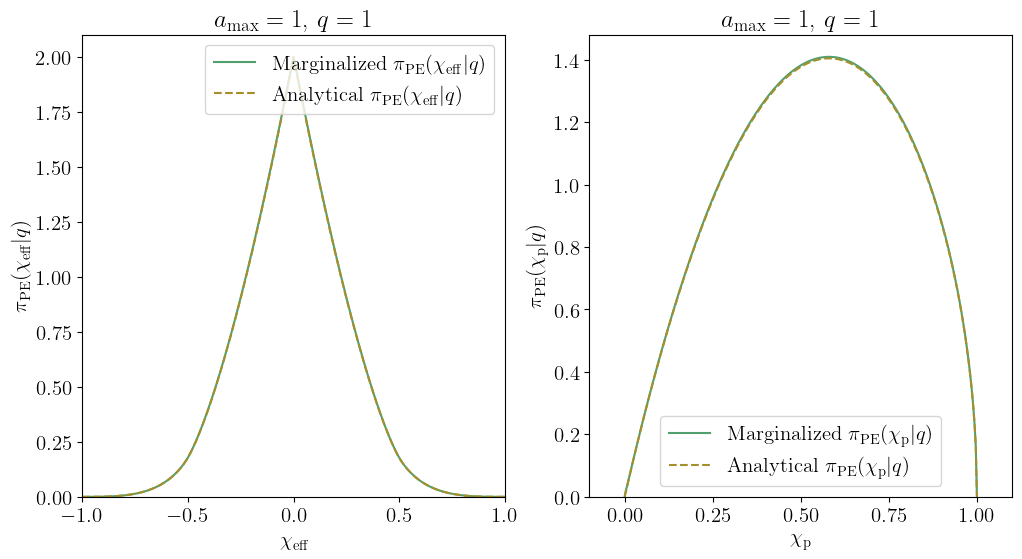

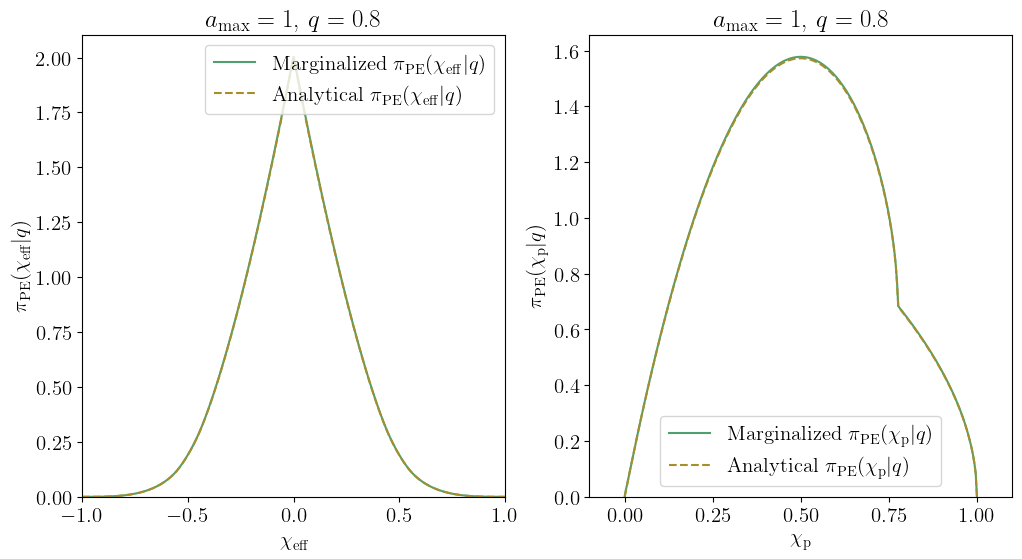

/var/folders/66/8jppf4p95ds2l0460r55s9rm0000gq/T/ipykernel_23363/536722402.py:135: RuntimeWarning: divide by zero encountered in divide
  -(1.+q)*x_E*np.log(q/((1.+q)*x_E-aMax))
/var/folders/66/8jppf4p95ds2l0460r55s9rm0000gq/T/ipykernel_23363/536722402.py:132: RuntimeWarning: invalid value encountered in multiply
  + np.log(aMax)*(
/var/folders/66/8jppf4p95ds2l0460r55s9rm0000gq/T/ipykernel_23363/536722402.py:137: RuntimeWarning: divide by zero encountered in log
  - aMax*np.log(((1.+q)*x_E-aMax)/q)
/var/folders/66/8jppf4p95ds2l0460r55s9rm0000gq/T/ipykernel_23363/536722402.py:138: RuntimeWarning: divide by zero encountered in log
  + (1.+q)*x_E*np.log(((1.+q)*x_E-aMax)*((1.+q)*x_E-q*aMax)/q)
/var/folders/66/8jppf4p95ds2l0460r55s9rm0000gq/T/ipykernel_23363/536722402.py:139: RuntimeWarning: divide by zero encountered in divide
  + (1.+q)*x_E*np.log((1.+q)*x_E)*np.log(q*aMax/((1.+q)*x_E-aMax))
/var/folders/66/8jppf4p95ds2l0460r55s9rm0000gq/T/ipykernel_23363/536722402.py:139: RuntimeWarning

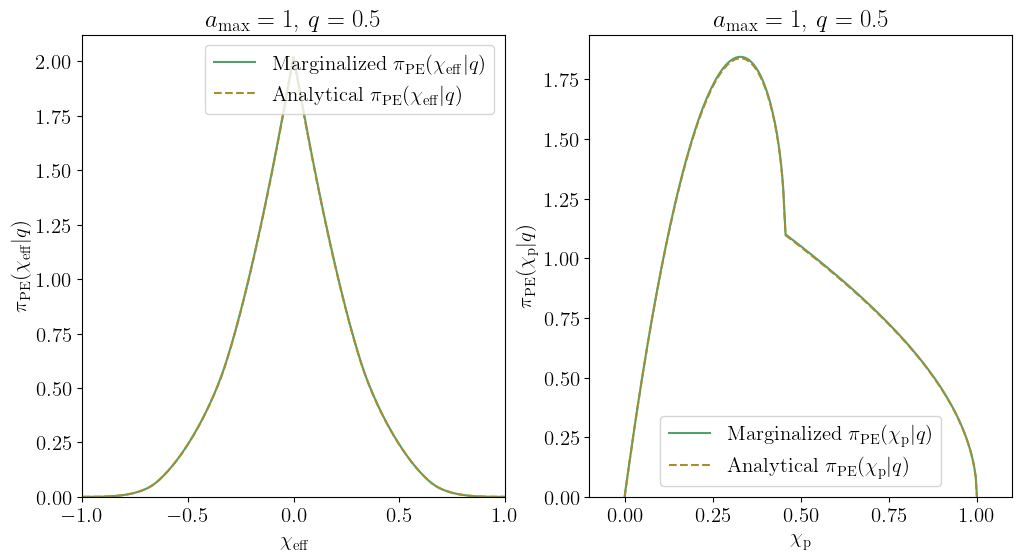

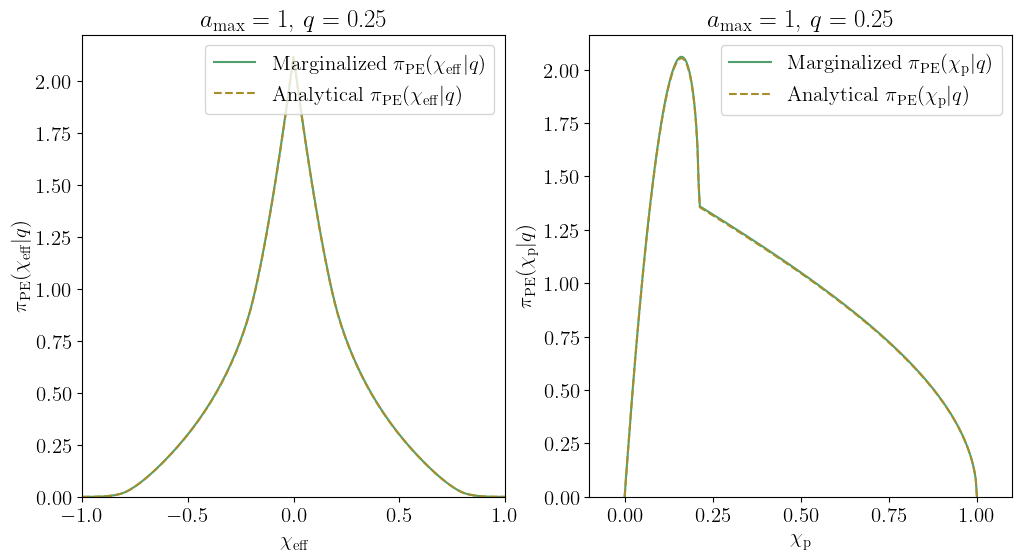

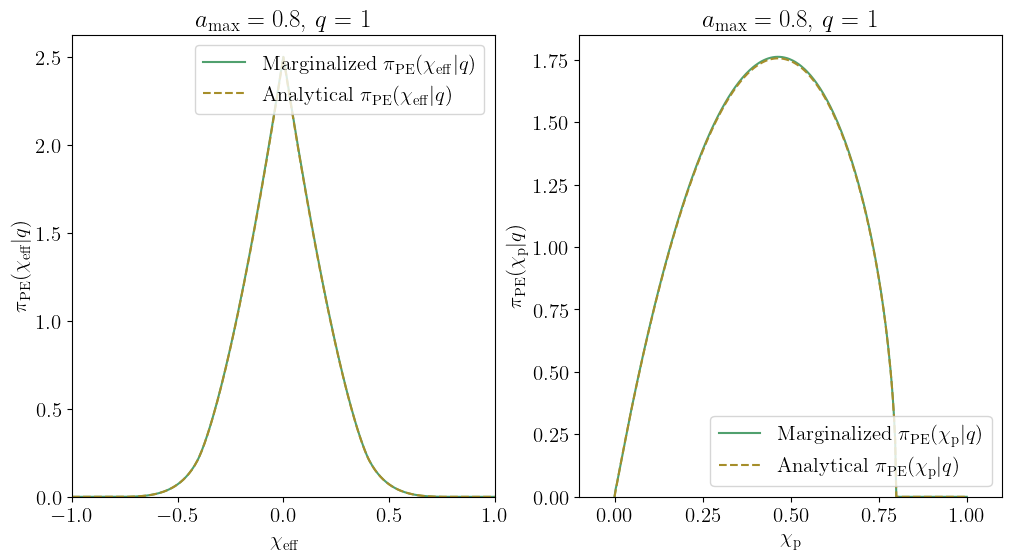

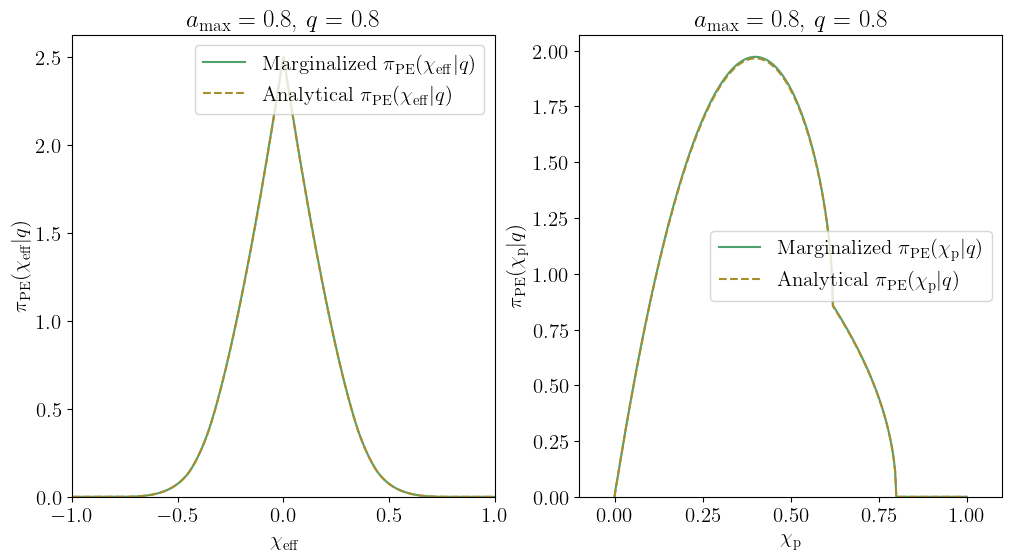

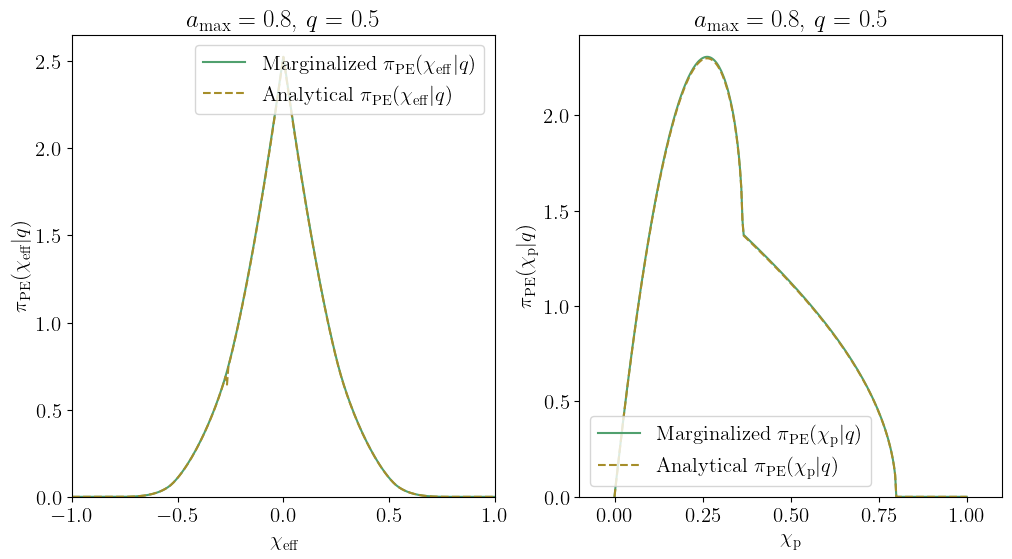

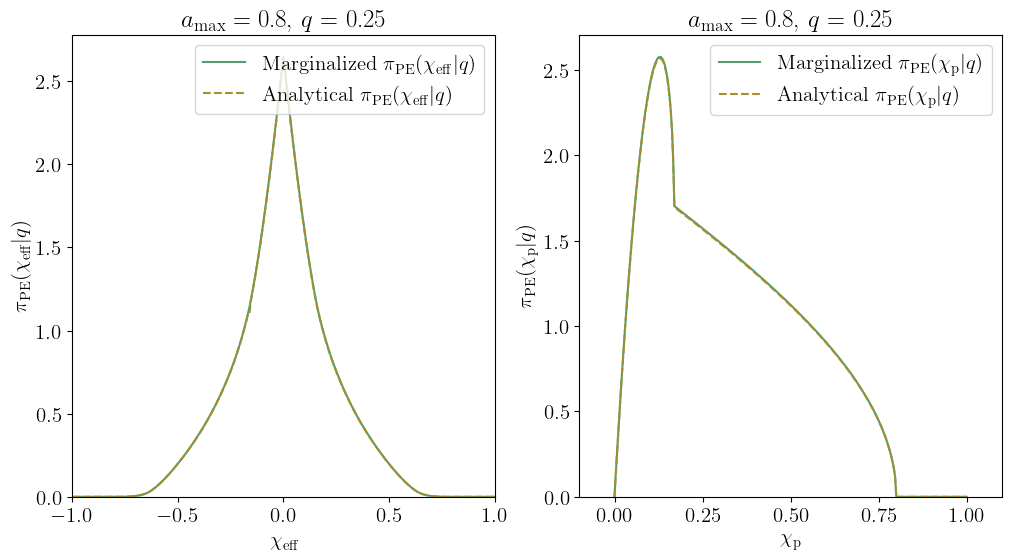

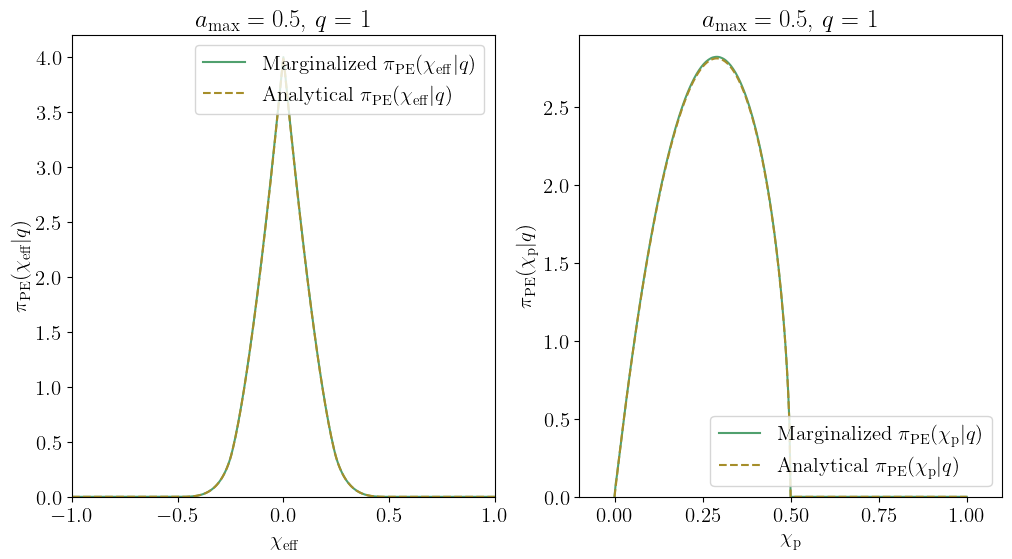

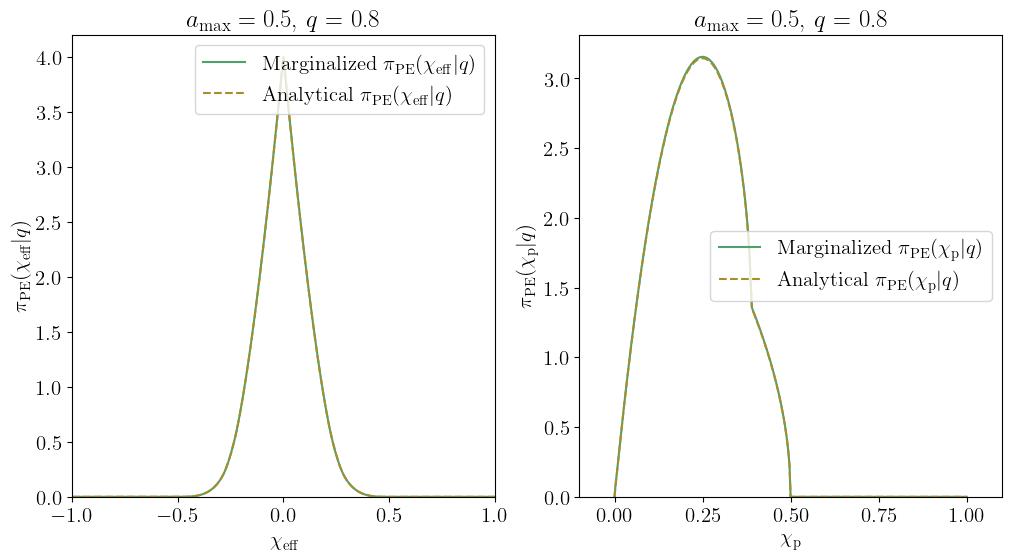

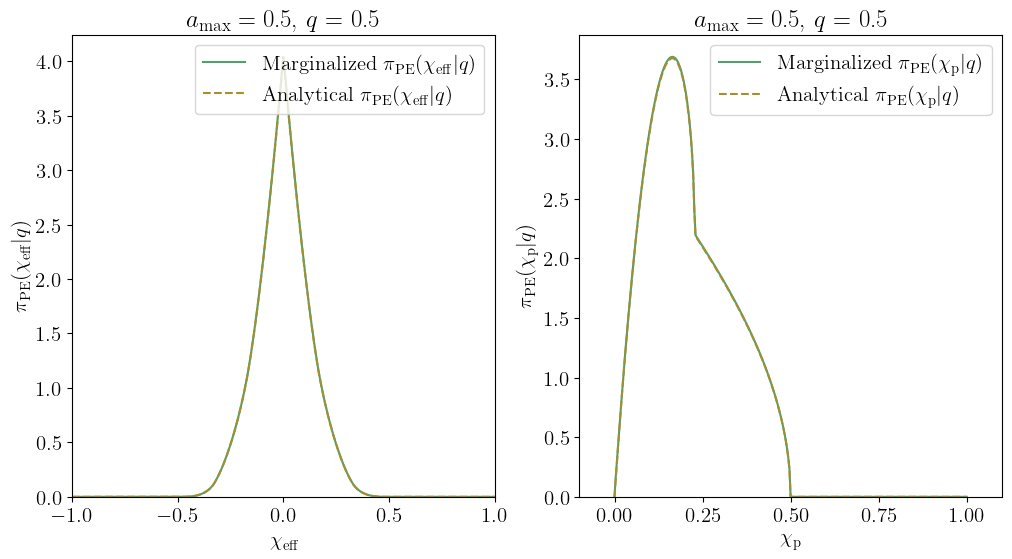

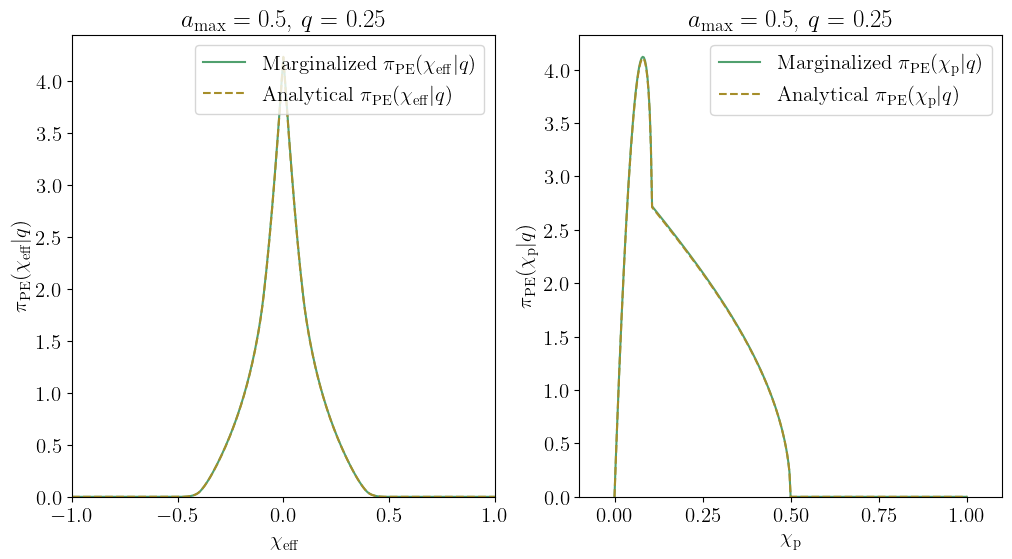

In [5]:
import matplotlib.pyplot as plt
Nmesh = 301
amax = 1

Xeff_grid = np.linspace(-1,1,Nmesh)
Xp_grid = np.linspace(0,1,Nmesh)
X,Y = np.meshgrid(Xeff_grid, Xp_grid)

for amax in [1,.8,.5]:
    for q in [1,.8,.5,.25]:
        fig,axes = plt.subplots(1,2,figsize = [12,6])
        ax1,ax2 = axes
        Z = Joint_prob_Xeff_Xp(X.reshape(Nmesh*Nmesh),Y.reshape(Nmesh*Nmesh),q = q,amax = amax).reshape(Nmesh,Nmesh)
        Z /= Z.sum()

        #Xeff comparison
        ax1.plot(Xeff_grid,np.sum(Z,axis = 0)*Nmesh/2,label=r"Marginalized $\pi_{\rm PE}(\chi_{\rm eff}|q)$",color=plot_green)
        ax1.plot(Xeff_grid,chi_effective_prior_from_isotropic_spins(q,amax,Xeff_grid),
                 label=r"Analytical $\pi_{\rm PE}(\chi_{\rm eff}|q)$",color=plot_gold,linestyle='--')
        ax1.set_xlabel(r'$\chi_{\rm eff}$')
        ax1.set_ylabel(r'$\pi_{\rm PE}(\chi_{\rm eff}|q)$')
        ax1.set_xlim([-1,1])
        ax1.set_ylim(ymin=0)
        ax1.set_title(r'$a_{\rm max} =$ '+r'{}, $q$ = {}'.format(amax,q))
        ax1.legend()
        
        #Xp comparison
        ax2.plot(Xp_grid,np.sum(Z,axis = 1)*Nmesh/1,label=r"Marginalized $\pi_{\rm PE}(\chi_{\rm p}|q)$",color=plot_green)
        ax2.plot(Xp_grid,chi_p_prior_from_isotropic_spins(q,amax,Xp_grid),
                 label=r"Analytical $\pi_{\rm PE}(\chi_{\rm p}|q)$",color=plot_gold,linestyle='--')
        ax2.set_xlabel(r'$\chi_{\rm p}$')
        ax2.set_ylabel(r'$\pi_{\rm PE}(\chi_{\rm p}|q)$')
        ax2.set_xlim([-0.1,1.1])
        ax2.set_ylim(ymin=0)
        ax2.set_title(r'$a_{\rm max} =$ '+r'{}, $q$ = {}'.format(amax,q))
        
        ax2.legend()
        plt.savefig(output_path+'Marginalized_a_{:.2f}_q_{:.2f}'.format(amax,q).replace('.','p')+'.pdf')
        plt.show()

## Simple KDE vs Analytical prior

Calculation time:27.56s


<Figure size 400x400 with 0 Axes>

<Figure size 600x600 with 0 Axes>

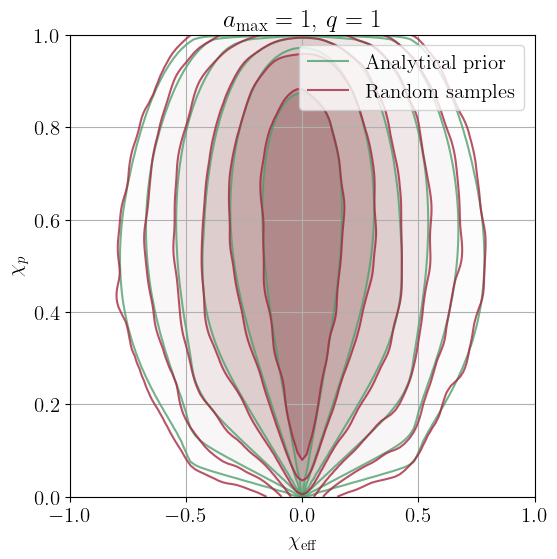

In [6]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
from scipy import interpolate
import time

ndraws = 250000
Nmesh = 101
levels = [scipy.special.erf(x/np.sqrt(2)) for x in [0.5,1,1.5,2,2.5,3]] #x sigmas

def chi_eff(a1,a2,cost1,cost2,q):
    return (a1*cost1+q*a2*cost2)/(1+q)

def chi_p(a1,a2,cost1,cost2,q):
    return chi_p_from_components(a1,a2,cost1,cost2,q)

for amax in [1]:
    for q in [1,]:
        plt.figure(figsize=(4,4))
        t0 = time.time()
        # Draw random component spins and compute effective parameters
        random_a1s = np.random.random(ndraws)*amax
        random_a2s = np.random.random(ndraws)*amax
        random_cost1s = 2.*np.random.random(ndraws)-1.
        random_cost2s = 2.*np.random.random(ndraws)-1.

        # Plot!
        random_chi_effs = chi_eff(random_a1s,random_a2s,random_cost1s,random_cost2s,q)
        random_chi_ps = chi_p(random_a1s,random_a2s,random_cost1s,random_cost2s,q) 
        
        plt.figure(figsize=(6,6))
        x = np.linspace(-amax, amax, Nmesh)
        y = np.linspace(0, amax, Nmesh)
        X,Y = np.meshgrid(x, y)
        Z = Joint_prob_Xeff_Xp(X.reshape(Nmesh*Nmesh),Y.reshape(Nmesh*Nmesh),q = q,amax = amax).reshape(Nmesh,Nmesh)
        Z = Z / Z.sum()
        Neval = 1000
        t = np.linspace(0, Z.max(), Neval)
        mask = (Z >= t[:, None, None])
        re_mask = mask*Z
        integral = re_mask.sum(axis=(1,2))
        f = interpolate.interp1d(integral, t)
        t_contours = f(np.array(levels))
                
        fig,ax =  plt.subplots(1,1,figsize = (6,6))
        cmap = LinearSegmentedColormap.from_list("", ["white",plot_green])
        cntr_analytical = ax.contour(Z,sorted(t_contours),extent=[-amax,amax,0,amax], colors = plot_green, alpha = 0.8)
        ax.contourf(x, y, Z, levels = list(sorted(t_contours))+[np.amax(Z)], alpha=0.5, cmap=cmap)
        pos = np.vstack([X.ravel(),Y.ravel()])
        #print(pos)
        values = np.vstack([random_chi_effs,random_chi_ps])
        kernel = gaussian_kde(values,bw_method='scott')

        z = np.reshape(kernel(pos),X.shape)
        z = z / z.sum()         

        Neval = 1000
        t = np.linspace(0, z.max(), Neval)
        mask = (z >= t[:, None, None])
        re_mask = mask*z
        integral = re_mask.sum(axis=(1,2))
        f = interpolate.interp1d(integral, t)
        t_contours = f(np.array(levels))
        cmap = LinearSegmentedColormap.from_list("", ["white",plot_red])
        cntr_KDE = ax.contour(z,sorted(t_contours),extent=[-amax,amax,0,amax], colors = plot_red, alpha = 0.8)
        ax.contourf(X,Y, z, levels = list(sorted(t_contours))+[np.amax(z)], alpha=0.5, cmap=cmap)
        
        #https://github.com/matplotlib/matplotlib/issues/11134
        hana,_ = cntr_analytical.legend_elements()
        hKDE,_ = cntr_KDE.legend_elements()
        ax.legend([hana[0], hKDE[0]], ['Analytical prior', 'Random samples'])
        
        ax.set_xlabel(r'$\chi_\mathrm{eff}$')
        ax.set_ylabel(r'$\chi_p$')
        plt.title(r'$a_{\rm max} =$ '+r'{}, $q$ = {}'.format(amax,q))
        plt.grid()
        plt.savefig(output_path+'Jointdist_a_{:.2f}_q_{:.2f}'.format(amax,q).replace('.','p')+'.pdf')
        print('Calculation time:{:.2f}s'.format(time.time()-t0))
        #plt.savefig(output_path+'Jointdist_a_1p00_q_{}p{:.2f}.pdf'.format())
        #plt.savefig('Jointdist_a_1p00_q_1p00.pdf')
        plt.show()

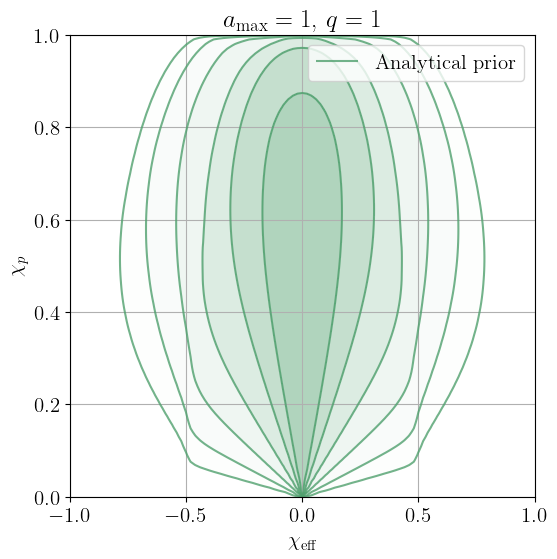

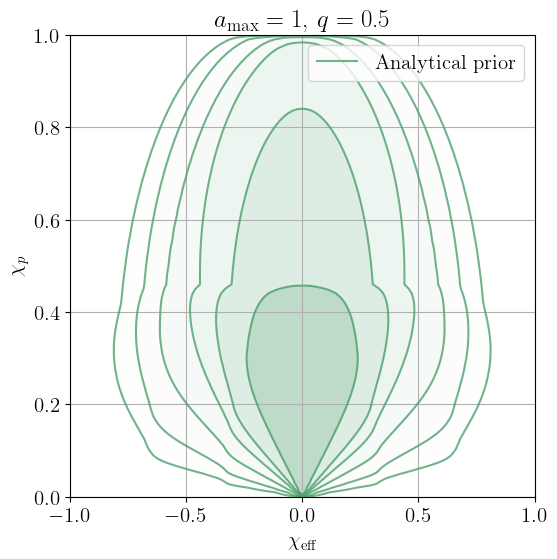

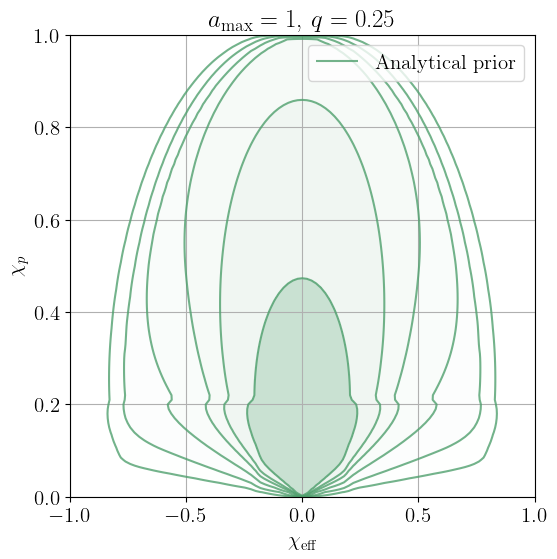

In [7]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
from scipy import interpolate
import time

ndraws = 250000
Nmesh = 101
levels = [scipy.special.erf(x/np.sqrt(2)) for x in [0.5,1,1.5,2,2.5,3]] #x sigmas

def chi_eff(a1,a2,cost1,cost2,q):
    return (a1*cost1+q*a2*cost2)/(1+q)

def chi_p(a1,a2,cost1,cost2,q):
    return chi_p_from_components(a1,a2,cost1,cost2,q)

for amax in [1]:
    for q in [1,.5,.25]:
        x = np.linspace(-amax, amax, Nmesh)
        y = np.linspace(0, amax, Nmesh)
        X,Y = np.meshgrid(x, y)
        Z = Joint_prob_Xeff_Xp(X.reshape(Nmesh*Nmesh),Y.reshape(Nmesh*Nmesh),q = q,amax = amax).reshape(Nmesh,Nmesh)
        Z = Z / Z.sum()
        Neval = 1000
        t = np.linspace(0, Z.max(), Neval)
        mask = (Z >= t[:, None, None])
        re_mask = mask*Z
        integral = re_mask.sum(axis=(1,2))
        f = interpolate.interp1d(integral, t)
        t_contours = f(np.array(levels))
                
        fig,ax =  plt.subplots(1,1,figsize = (6,6))
        cmap = LinearSegmentedColormap.from_list("", ["white",plot_green])
        cntr_analytical = ax.contour(Z,sorted(t_contours),extent=[-amax,amax,0,amax], colors = plot_green, alpha = 0.8)
        ax.contourf(x, y, Z, levels = list(sorted(t_contours))+[np.amax(Z)], alpha=0.5, cmap=cmap)
        
        #https://github.com/matplotlib/matplotlib/issues/11134
        hana,_ = cntr_analytical.legend_elements()
        ax.legend([hana[0]], ['Analytical prior'])
        
        ax.set_xlabel(r'$\chi_\mathrm{eff}$')
        ax.set_ylabel(r'$\chi_p$')
        plt.title(r'$a_{\rm max} =$ '+r'{}, $q$ = {}'.format(amax,q))
        plt.grid()
        plt.show()

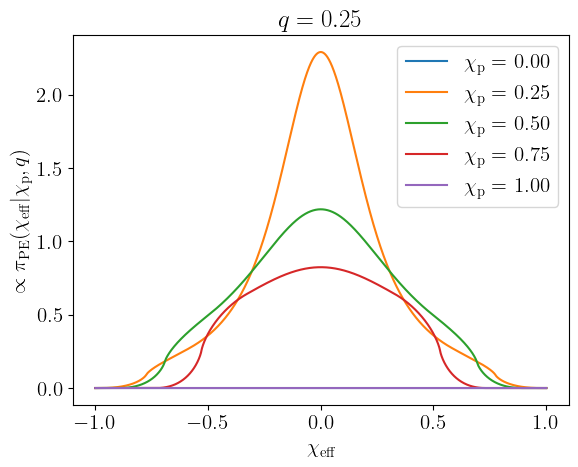

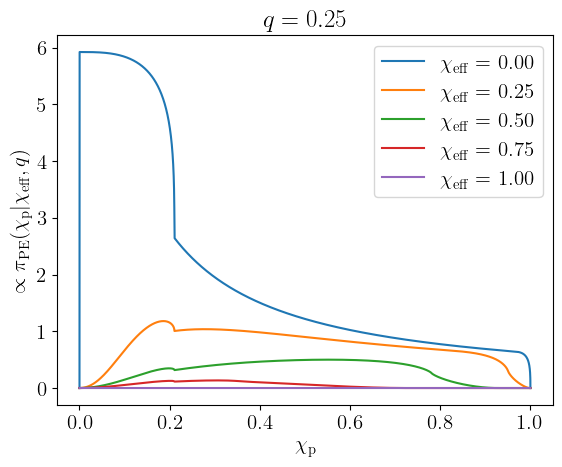

In [8]:
q = 0.25
for target_Xp in np.linspace(0,1,5):
    Xeff_grid = np.linspace(-1,1,10001)
    plt.plot(Xeff_grid,Joint_prob_Xeff_Xp(Xeff_grid,target_Xp,q),label=r'$\chi_{\rm p}=$'+' {:.2f}'.format(target_Xp))
plt.xlabel(r'$\chi_{\rm eff}$')
plt.ylabel(r'$\propto \pi_{\rm PE}(\chi_{\rm eff}|\chi_{\rm p},q)$')
plt.title(r'$q = {:.2f}$'.format(q))
plt.legend()
plt.show()

for target_Xeff in np.linspace(0,1,5):
    Xp_grid = np.linspace(0,1,10001)
    plt.plot(Xp_grid,Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q),label=r'$\chi_{\rm eff}=$'+' {:.2f}'.format(target_Xeff))
plt.xlabel(r'$\chi_{\rm p}$')
plt.ylabel(r'$\propto \pi_{\rm PE}(\chi_{\rm p}|\chi_{\rm eff},q)$')
plt.title(r'$q = {:.2f}$'.format(q))
plt.legend()
plt.show()

## Comparisons of $p(\chi_{\rm p}|\chi_{\rm eff},q)$, given some $\chi_{\rm eff},q$

### Behavor of reference KDE that internally run when computing $p(\chi_{\rm p}|\chi_{\rm eff},q)$

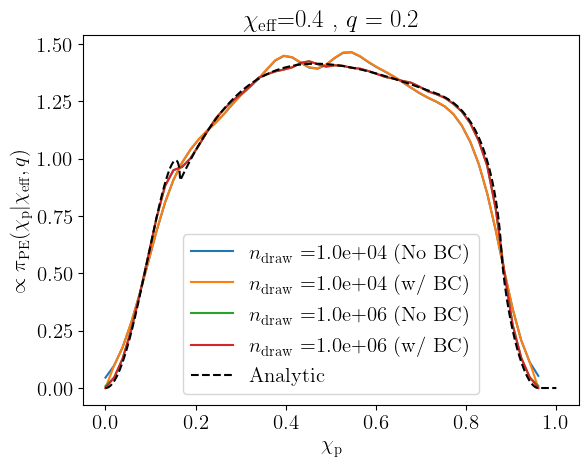

In [9]:
target_Xeff = 0.4
q = 0.2
aMax = 1

for ndraws in [10000,1000000]:
    a1,a2,cost2 = np.zeros((3,ndraws))
    cost1 = np.ones(ndraws)*2
    while np.any(cost1<-1) or np.any(cost1>1):   
        to_replace = np.where((cost1<-1) | (cost1>1))[0]   
        a1[to_replace] = np.random.random(to_replace.size)*aMax
        a2[to_replace] = np.random.random(to_replace.size)*aMax
        cost2[to_replace] = 2.*np.random.random(to_replace.size)-1.    
        cost1 = (target_Xeff*(1.+q) - q*a2*cost2)/a1
        
    jacobian_weights = (1.+q)/a1
    prior_kde = gaussian_kde(chi_p(a1,a2,cost1,cost2,q),weights=jacobian_weights,bw_method='scott')
    
    if (1.+q)*np.abs(target_Xeff)/q<aMax:
        max_Xp = 1
    else:
        max_Xp = np.sqrt(aMax*aMax - ((1.+q)*np.abs(target_Xeff)-q)**2.)
    
    reference_grid = np.linspace(0.02*max_Xp,0.98*max_Xp,50)
    reference_vals = prior_kde(reference_grid)

    # Manually prepend/append zeros at the boundaries
    reference_grid = np.concatenate([[0],reference_grid,[max_Xp]])
    reference_vals_ = prior_kde(reference_grid)
    norm_constant = np.trapz(reference_vals_,reference_grid)
    plt.plot(reference_grid,reference_vals_/norm_constant,label=r'$n_{\rm draw}$ ='+'{:.1e} (No BC)'.format(ndraws))
    
    reference_vals = np.concatenate([[0],reference_vals,[0]])
    norm_constant = np.trapz(reference_vals,reference_grid)

    plt.plot(reference_grid,reference_vals/norm_constant,label=r'$n_{\rm draw}$ ='+'{:.1e} (w/ BC)'.format(ndraws))

Xp_grid = np.linspace(0,1,1001)
plt.plot(Xp_grid,Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q)/chi_effective_prior_from_isotropic_spins(q,1,target_Xeff),label='Analytic',linestyle='--',color='black')   
plt.xlabel(r'$\chi_{\rm p}$')
plt.ylabel(r'$\propto \pi_{\rm PE}(\chi_{\rm p}|\chi_{\rm eff},q)$')
plt.title(r'$\chi_{\rm eff}$'+'={} , $q$ = {}'.format(target_Xeff,q))
plt.legend()
plt.show()

In [10]:
os.listdir(calculation_path)

['pXeff_Xp_0p01_q_0p20.npy',
 'pXeff_Xp_0p20_q_0p50.npy',
 'pXp_Xeff_0p10_q_0p20.npy',
 'pXp_zoomed_Xeff_0p20_q_0p80.npy',
 'pXp_Xeff_0p01_q_0p20.npy',
 'pXp_zoomed_Xeff_0p20_q_1p00.npy',
 'pXeff_Xp_0p10_q_0p20.npy',
 'pXp_Xeff_0p20_q_0p50.npy',
 'pXp_zoomed_Xeff_0p20_q_0p50.npy',
 'pXp_Xeff_0p20_q_1p00.npy',
 'pXeff_Xp_0p20_q_0p80.npy',
 'pXp_zoomed_Xeff_0p01_q_0p20.npy',
 'pXp_Xeff_0p20_q_0p80.npy',
 'pXp_zoomed_Xeff_0p10_q_0p20.npy',
 'pXeff_Xp_0p20_q_1p00.npy',
 'pXp_zoomed_Xeff_0p01_q_0p50.npy',
 'pXeff_Xp_0p01_q_0p80.npy',
 'pXp_Xeff_0p01_q_1p00.npy',
 'pXp_zoomed_Xeff_0p20_q_0p20.npy',
 'pXp_Xeff_0p10_q_0p80.npy',
 'pXeff_Xp_0p10_q_1p00.npy',
 'pXeff_Xp_0p01_q_1p00.npy',
 'pXp_Xeff_0p01_q_0p80.npy',
 'pXp_Xeff_0p10_q_1p00.npy',
 'pXeff_Xp_0p10_q_0p80.npy',
 'pXp_zoomed_Xeff_0p10_q_0p50.npy',
 'pXp_Xeff_0p10_q_0p50.npy',
 'pXp_zoomed_Xeff_0p10_q_1p00.npy',
 'pXeff_Xp_0p20_q_0p20.npy',
 'pXeff_Xp_0p01_q_0p50.npy',
 'pXp_zoomed_Xeff_0p01_q_0p80.npy',
 'pXp_zoomed_Xeff_0p10_q_0p80.n

## Check behavours of priors

pXp_Xeff_0p00_q_0p20.npy
[0.0, 0.2]


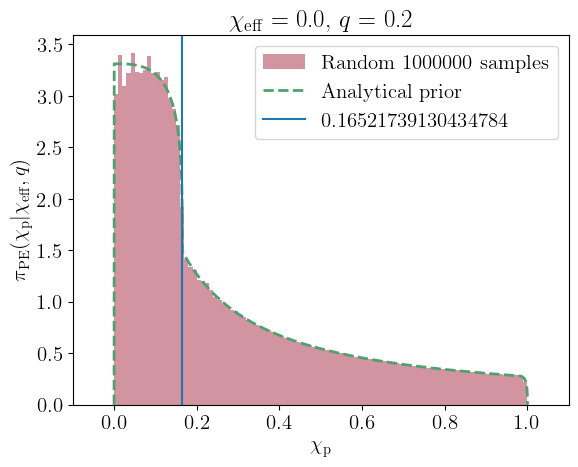

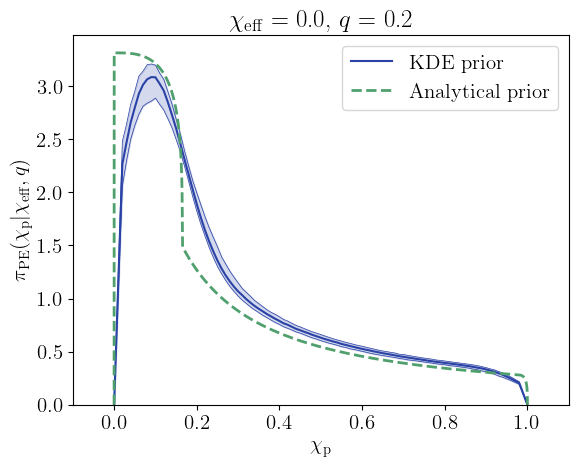

pXp_Xeff_0p00_q_0p50.npy
[0.0, 0.5]


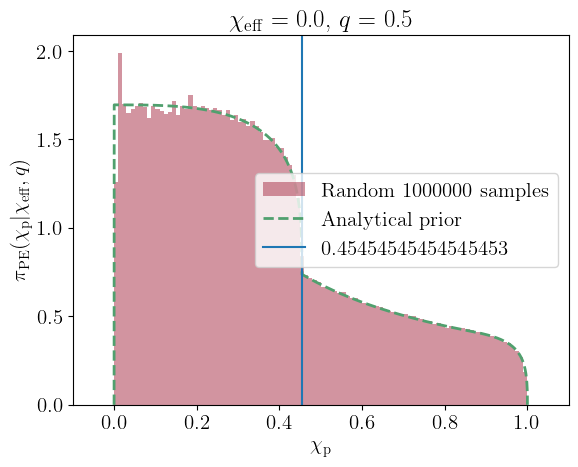

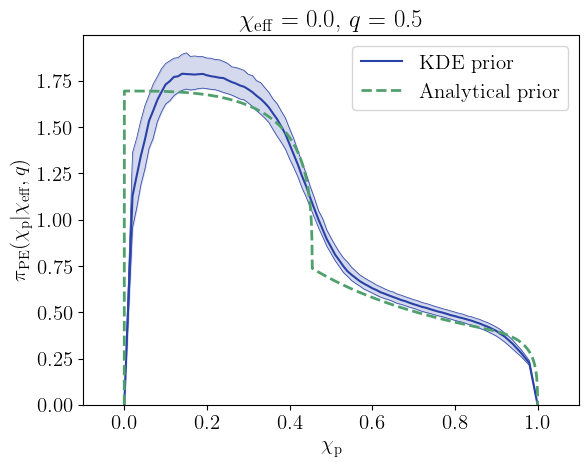

pXp_Xeff_0p00_q_0p80.npy
[0.0, 0.8]


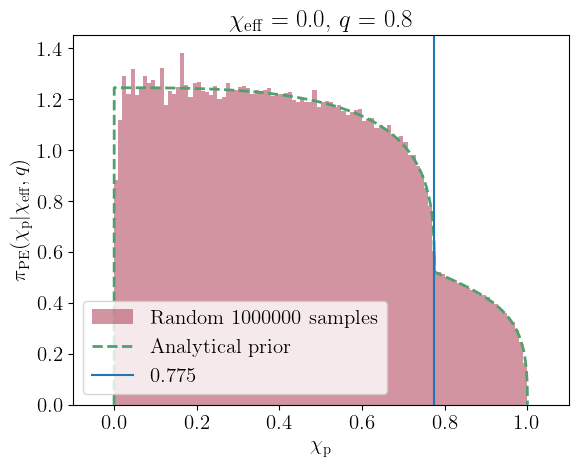

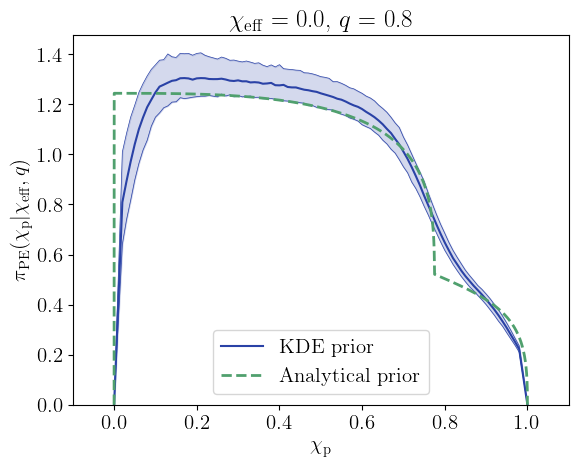

pXp_Xeff_0p00_q_1p00.npy
[0.0, 1.0]


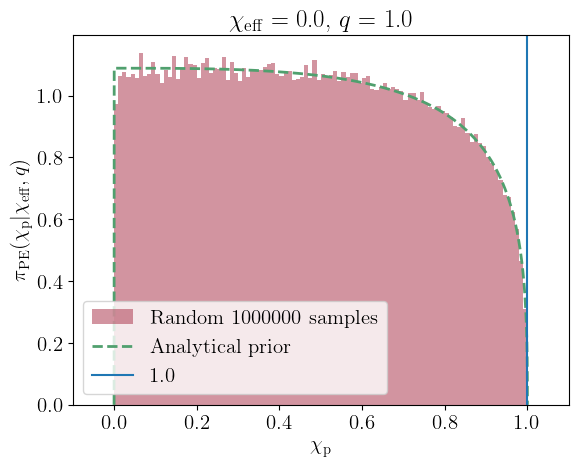

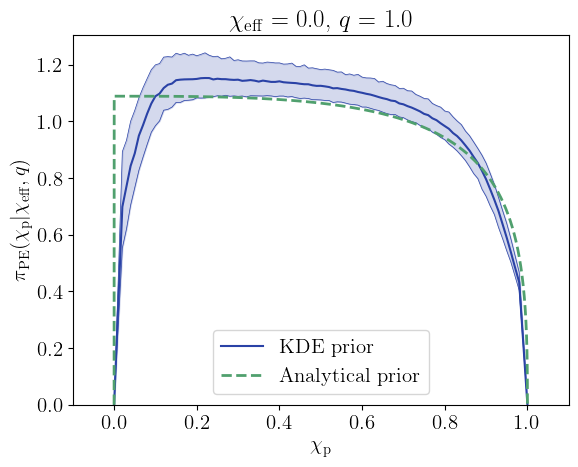

pXp_Xeff_0p01_q_0p20.npy
[0.01, 0.2]


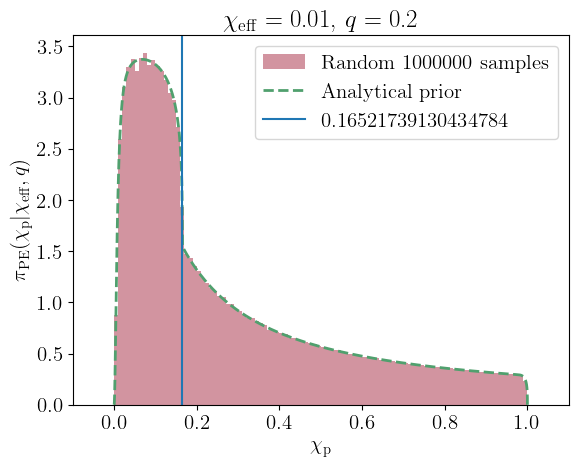

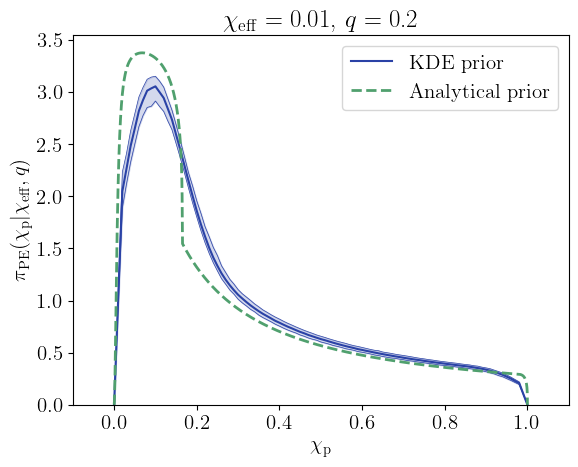

pXp_Xeff_0p01_q_0p50.npy
[0.01, 0.5]


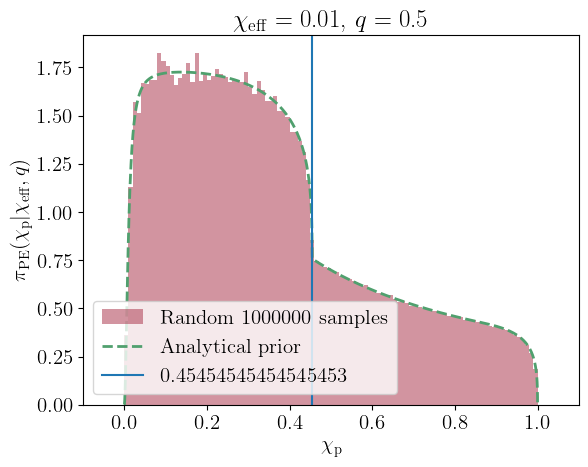

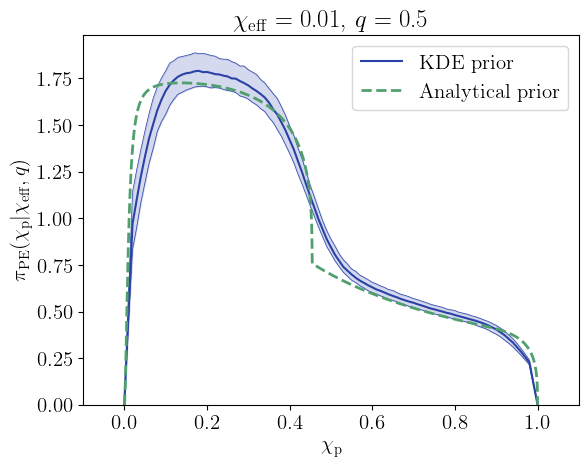

pXp_Xeff_0p01_q_0p80.npy
[0.01, 0.8]


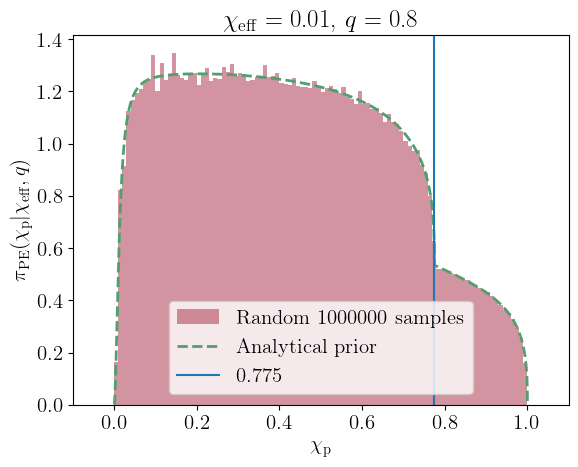

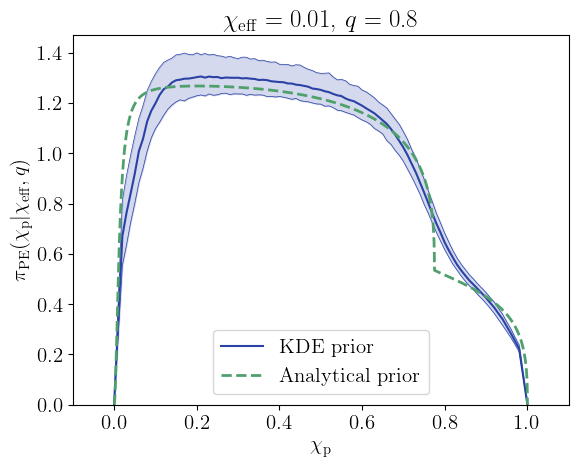

pXp_Xeff_0p01_q_1p00.npy
[0.01, 1.0]


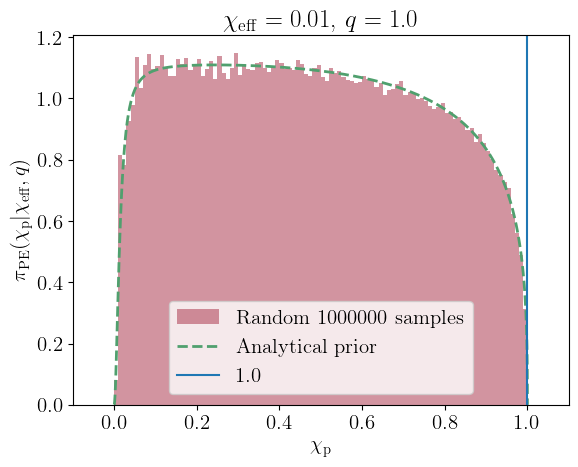

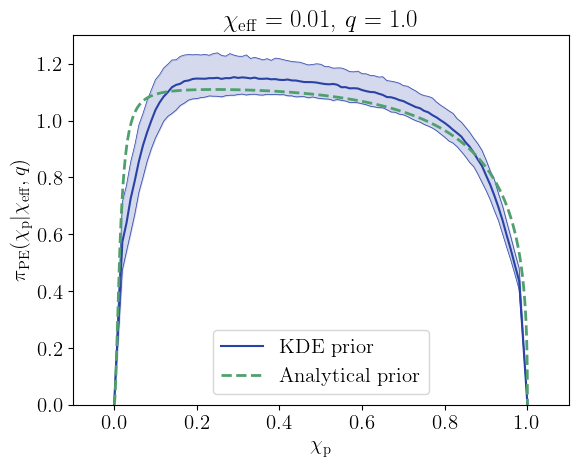

pXp_Xeff_0p10_q_0p20.npy
[0.1, 0.2]


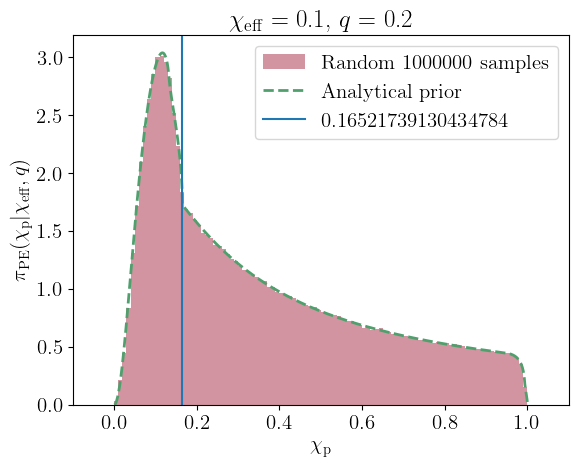

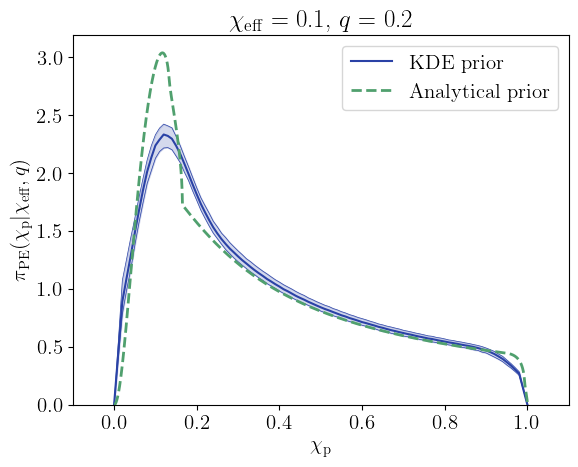

pXp_Xeff_0p10_q_0p50.npy
[0.1, 0.5]


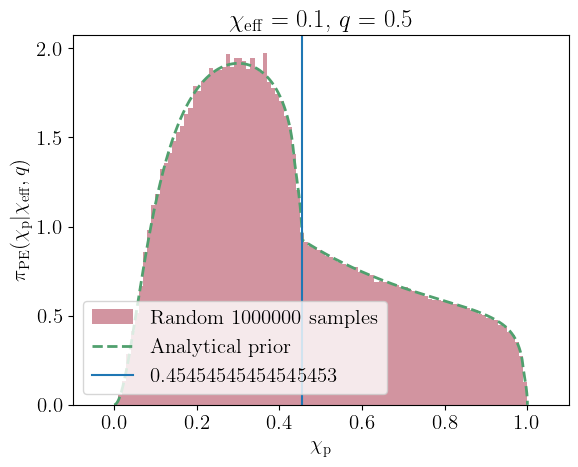

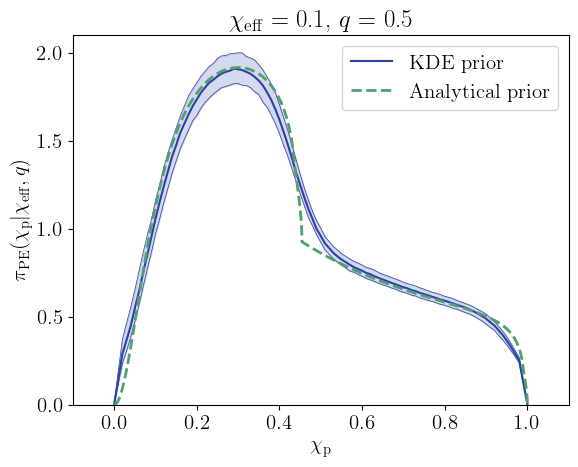

pXp_Xeff_0p10_q_0p80.npy
[0.1, 0.8]


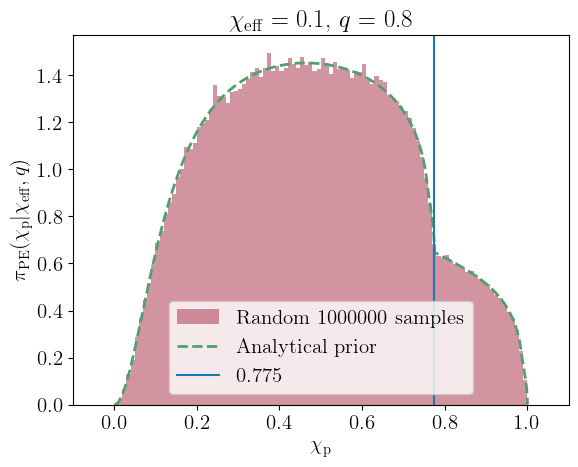

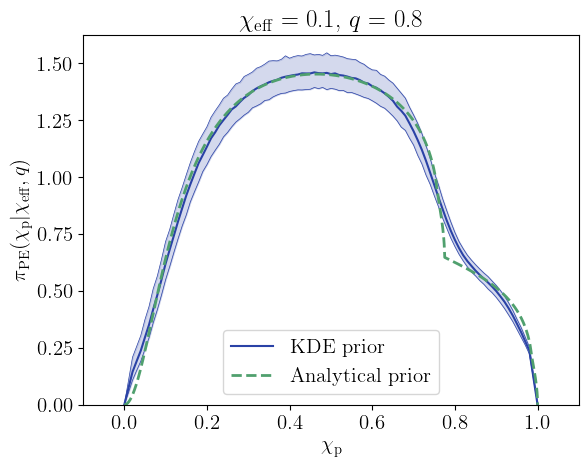

pXp_Xeff_0p10_q_1p00.npy
[0.1, 1.0]


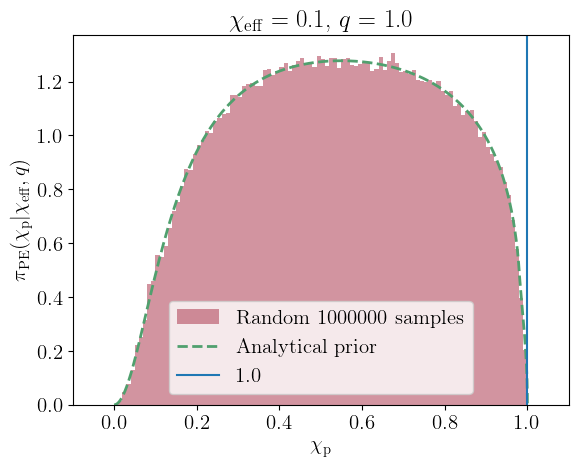

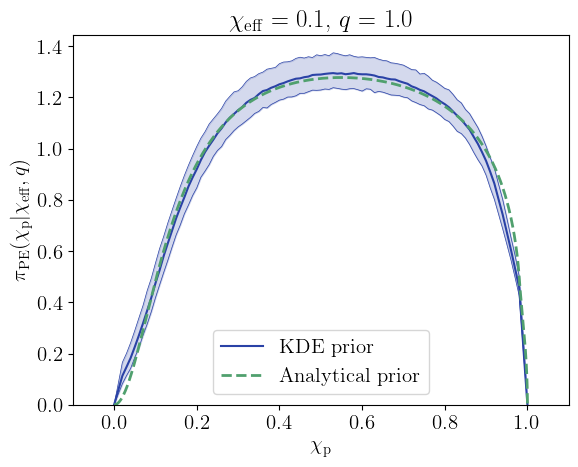

pXp_Xeff_0p20_q_0p20.npy
[0.2, 0.2]


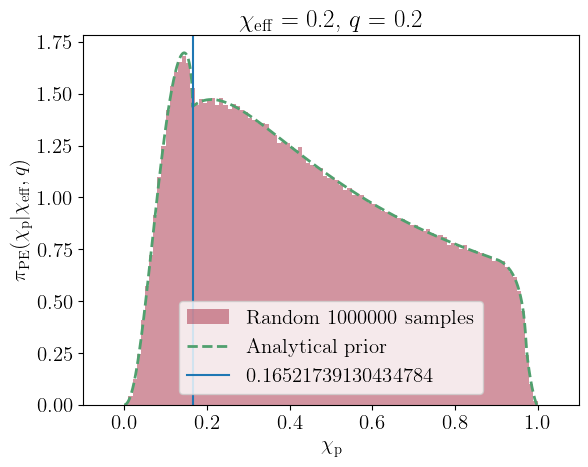

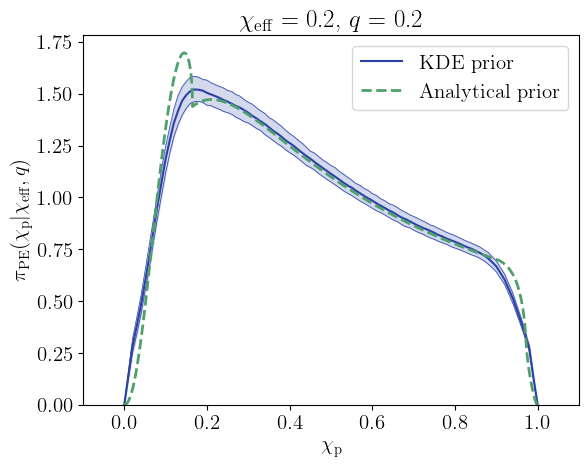

pXp_Xeff_0p20_q_0p50.npy
[0.2, 0.5]


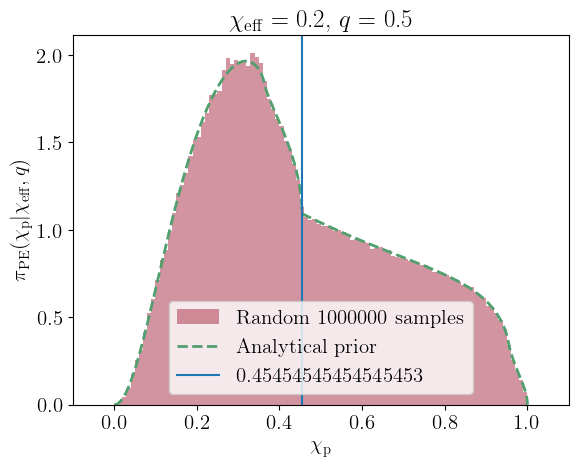

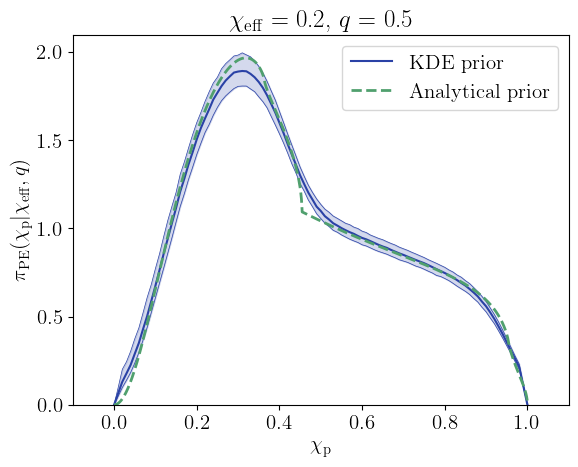

pXp_Xeff_0p20_q_0p80.npy
[0.2, 0.8]


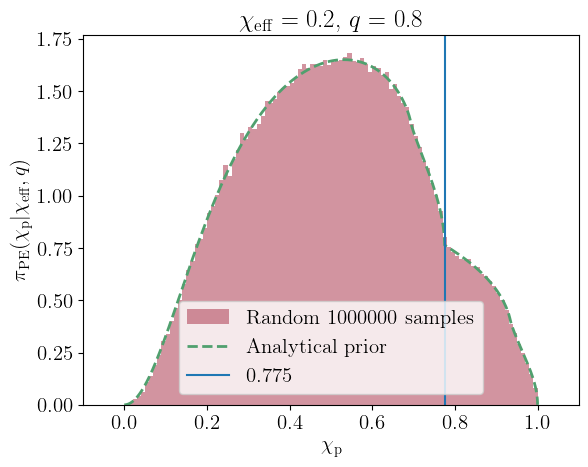

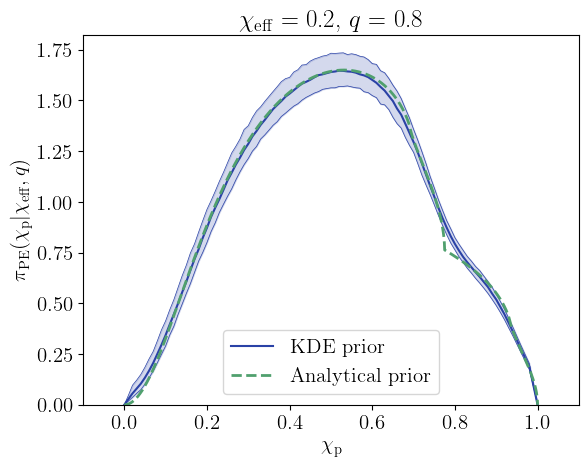

pXp_Xeff_0p20_q_1p00.npy
[0.2, 1.0]


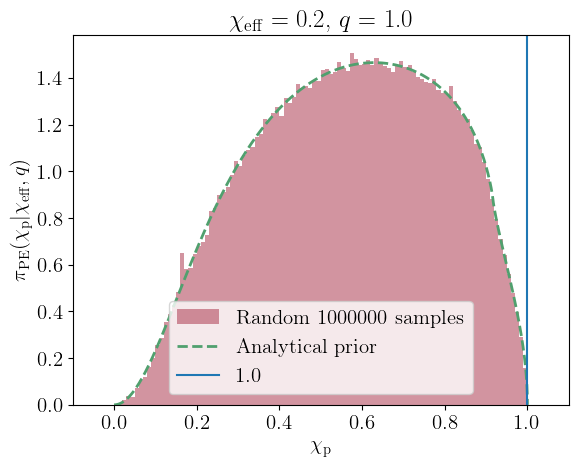

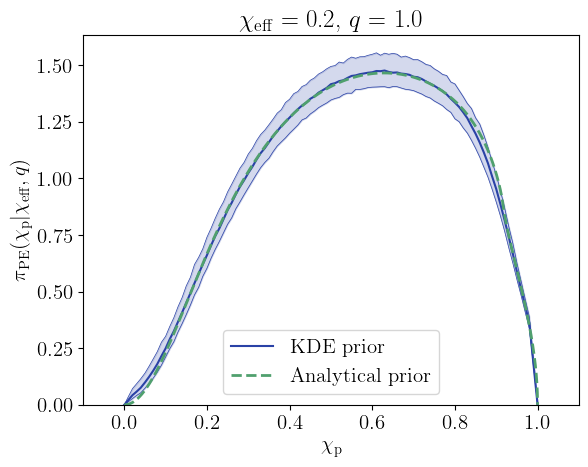

pXp_Xeff_0p50_q_0p20.npy
[0.5, 0.2]


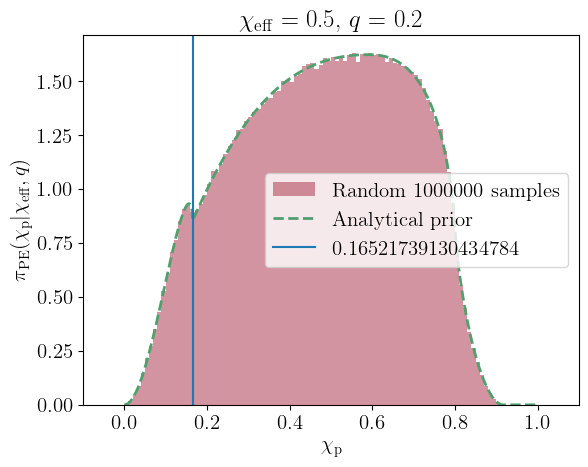

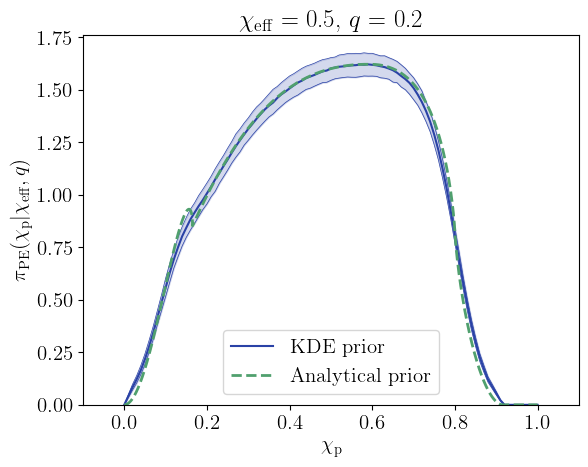

pXp_Xeff_0p50_q_0p50.npy
[0.5, 0.5]


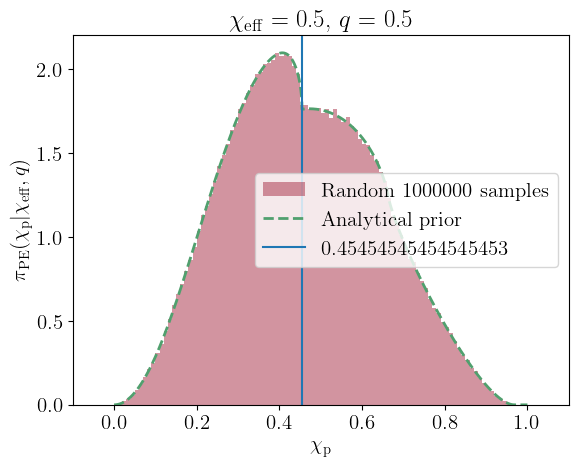

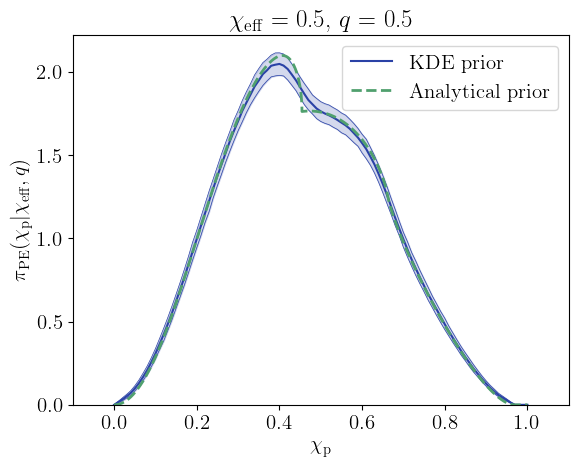

pXp_Xeff_0p50_q_0p80.npy
[0.5, 0.8]


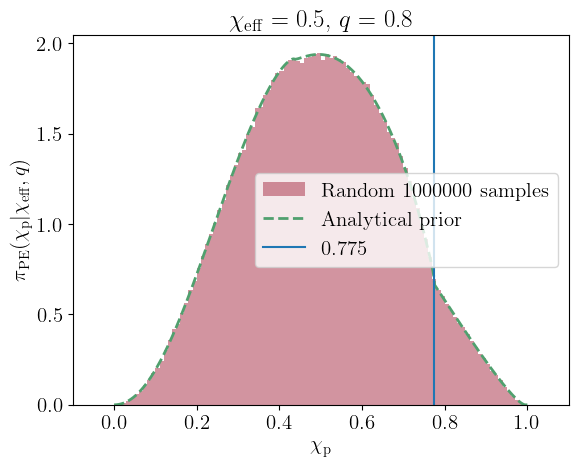

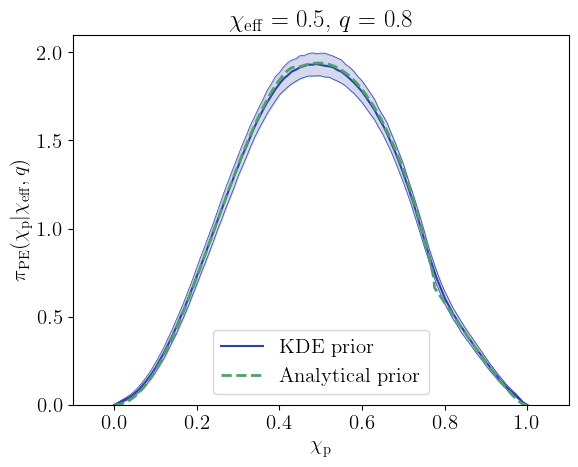

pXp_Xeff_0p50_q_1p00.npy
[0.5, 1.0]


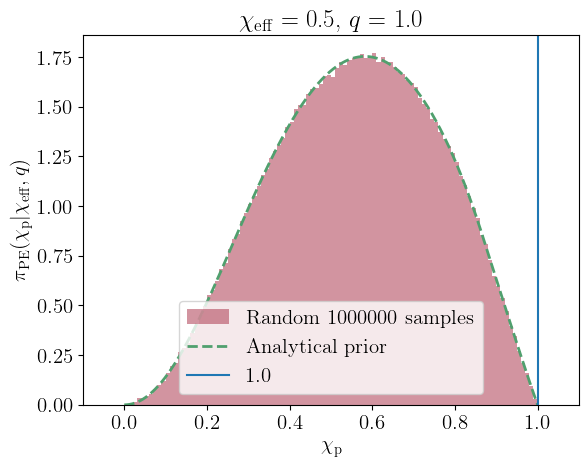

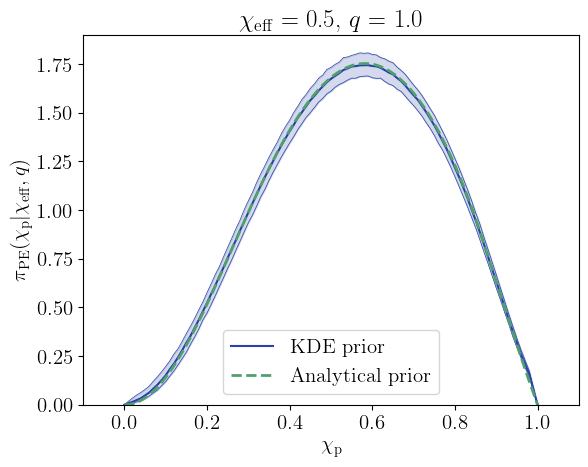

In [11]:
from tqdm.auto import tqdm
import time

ndraws = 1000000

aMax = 1


for file in sorted(os.listdir(calculation_path)):
    if file.startswith('pXp_Xeff_'):
        print(file)
        Xp_grid = np.linspace(0,1,101)
        
        data = np.load(calculation_path+file)
        lst = [l for l in file.split('_')]
        llst = []
        for l in lst:
            if '0' in l:
                llst.append(float(l.replace('.npy','').replace('p','.')))
        print(llst)
        
        target_Xeff,q = llst
                
        
        #Draw Histogram
        #Same method when KDE prio construct pdf
        a1,a2,cost2 = np.zeros((3,ndraws))    
        cost1 = np.ones(ndraws)*2
        
        while np.any(cost1<-1) or np.any(cost1>1):   
            to_replace = np.where((cost1<-1) | (cost1>1))[0]   
            a1[to_replace] = np.random.random(to_replace.size)*aMax
            a2[to_replace] = np.random.random(to_replace.size)*aMax
            cost2[to_replace] = 2.*np.random.random(to_replace.size)-1.    
            cost1 = (target_Xeff*(1.+q) - q*a2*cost2)/a1
        
        plt.hist(chi_p(a1,a2,cost1,cost2,q),range=[0,1],weights=(1.+q)/a1,bins=100,density = True,
                 alpha=0.5,label='Random {} samples'.format(ndraws),color=plot_red)
        
        
        #Draw KDE prior
        #unnorm_KDE = data[:,i]
        #norm_KDE_priors = unnorm_KDE/((np.sum(unnorm_KDE))*(Xp_grid[1]-Xp_grid[0]))
        #plt.plot(Xp_grid,norm_KDE_priors,color=plot_blue,label='KDE prior')
        
        #Draw Analytic prior
        Xp_grid = np.linspace(0,1,10001)
        unnormalized_pXp = Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q)
        normalized_pXp = unnormalized_pXp/((np.sum(unnormalized_pXp))*(Xp_grid[1]-Xp_grid[0]))
        plt.plot(Xp_grid,normalized_pXp,label='Analytical prior',color=plot_green,linewidth=2,linestyle='--')
        
        
        if (1+q)*target_Xeff <= 1:
            X2_limit = (3+4*q)/(4+3*q)*np.sqrt(q*q)
        else:
            X2_limit = (3+4*q)/(4+3*q)*np.sqrt(q*q-(1-(1+q)*target_Xeff)**2)
        plt.axvline(X2_limit,label='{}'.format((3+4*q)/(4+3*q)*np.sqrt(q*q)))
        plt.title(r'$\chi_{\rm eff}$ = '+'{}, $q$ = {}'.format(target_Xeff,q))
        plt.xlabel(r'$\chi_{\rm p}$')
        plt.ylabel(r'$\pi_{\rm PE}(\chi_{\rm p}|\chi_{\rm eff},q)$')
        plt.legend()
        plt.xlim([-0.1,1.1])
        #plt.savefig(output_path+file.replace('.npy','_vs_Hist.pdf'))    
        plt.show()        
        
        #Draw KDE prior
        Xp_grid = np.linspace(0,1,101)
        unnormalized_pXp = Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q)
        data /= ((np.sum(unnormalized_pXp))*(Xp_grid[1]-Xp_grid[0]))
        plt.plot(Xp_grid,np.quantile(data,axis=1,q=0.5),color=plot_blue,label='KDE prior')
        plt.plot(Xp_grid,np.quantile(data,axis=1,q=0.05),color=plot_blue,linewidth=0.5)
        plt.plot(Xp_grid,np.quantile(data,axis=1,q=0.95),color=plot_blue,linewidth=0.5)
        plt.fill_between(Xp_grid,np.quantile(data,q=0.05,axis=1),np.quantile(data,q=0.95,axis=1),color=plot_blue,alpha=0.2)
        
        #Draw Analytic prior
        Xp_grid = np.linspace(0,1,10001)
        unnormalized_pXp = Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q)
        normalized_pXp = unnormalized_pXp/((np.sum(unnormalized_pXp))*(Xp_grid[1]-Xp_grid[0]))
        plt.plot(Xp_grid,normalized_pXp,label='Analytical prior',color=plot_green,linewidth=2,linestyle='--')
        
        
        plt.title(r'$\chi_{\rm eff}$ = '+'{}, $q$ = {}'.format(target_Xeff,q))
        plt.xlabel(r'$\chi_{\rm p}$')
        plt.ylabel(r'$\pi_{\rm PE}(\chi_{\rm p}|\chi_{\rm eff},q)$')
        plt.legend()
        plt.xlim([-0.1,1.1])
        plt.ylim(ymin=0)
        #plt.savefig(output_path+file.replace('.npy','.pdf'))
        plt.show()

pXp_Xeff_0p00_q_0p20.npy
[0.0, 0.2]


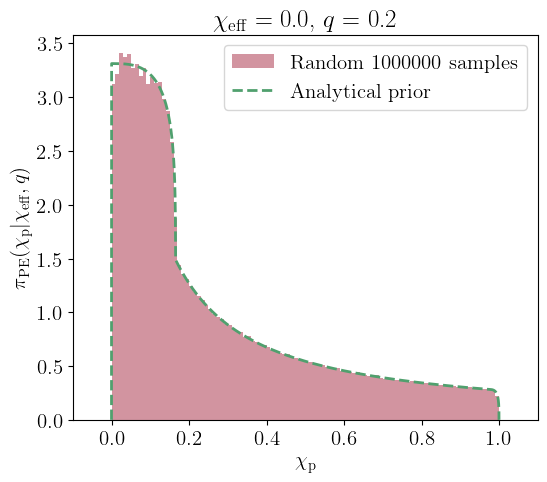

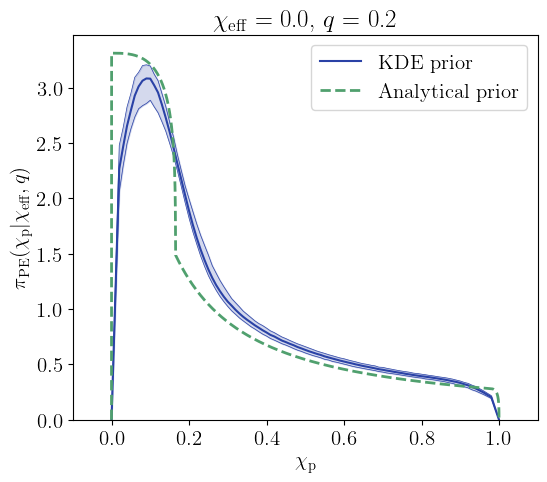

pXp_Xeff_0p00_q_0p50.npy
[0.0, 0.5]


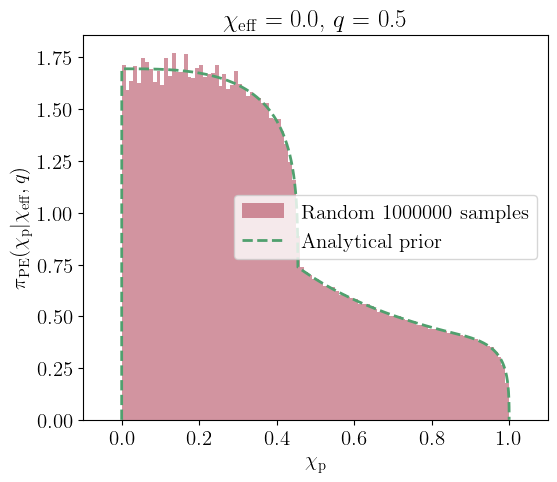

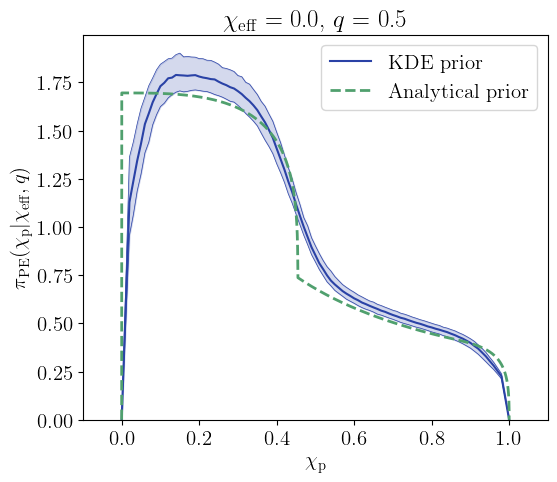

pXp_Xeff_0p00_q_0p80.npy
[0.0, 0.8]


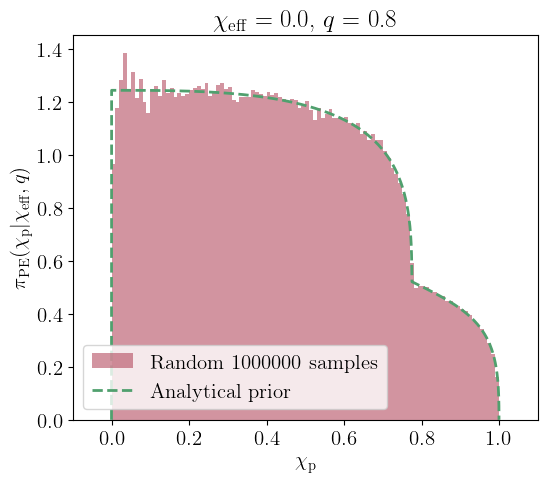

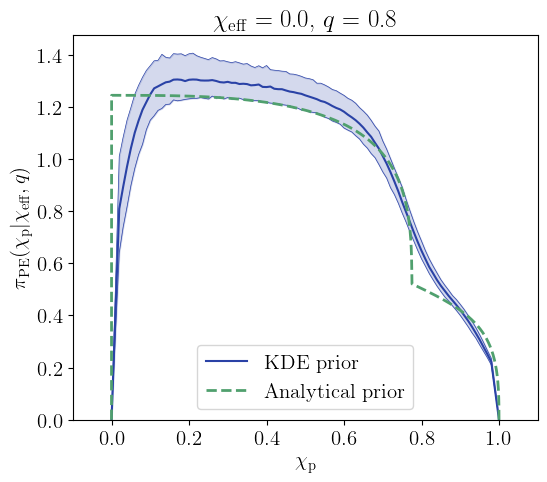

pXp_Xeff_0p00_q_1p00.npy
[0.0, 1.0]


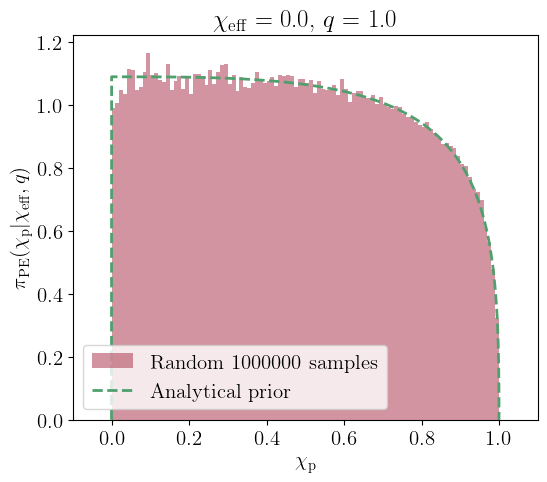

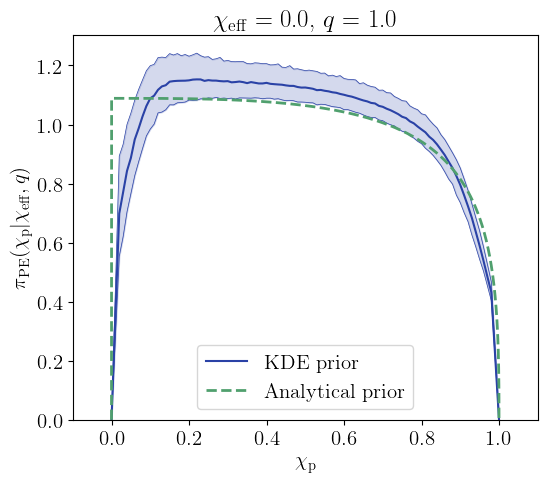

pXp_Xeff_0p01_q_0p20.npy
[0.01, 0.2]


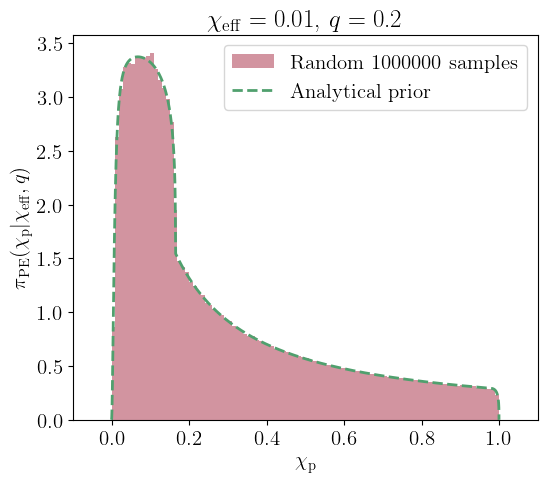

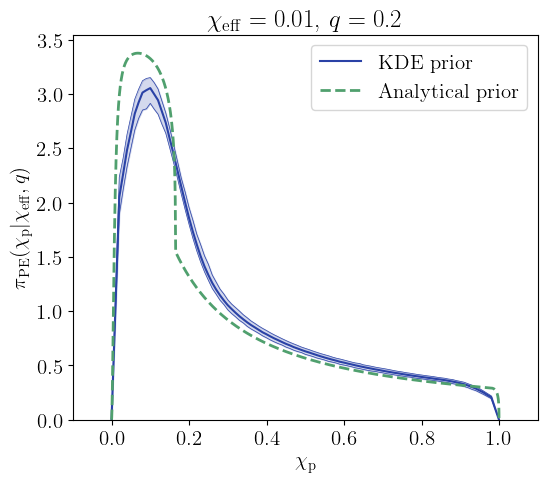

pXp_Xeff_0p01_q_0p50.npy
[0.01, 0.5]


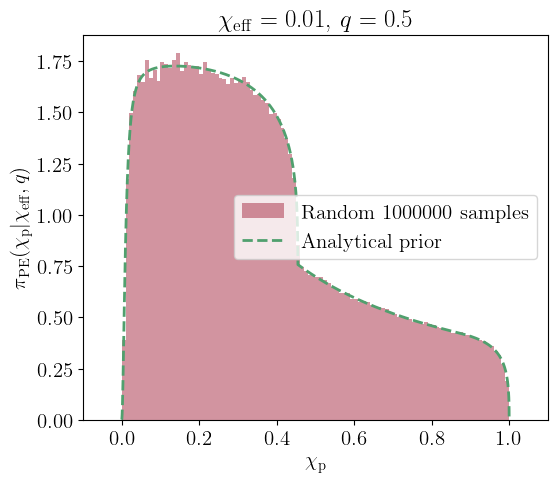

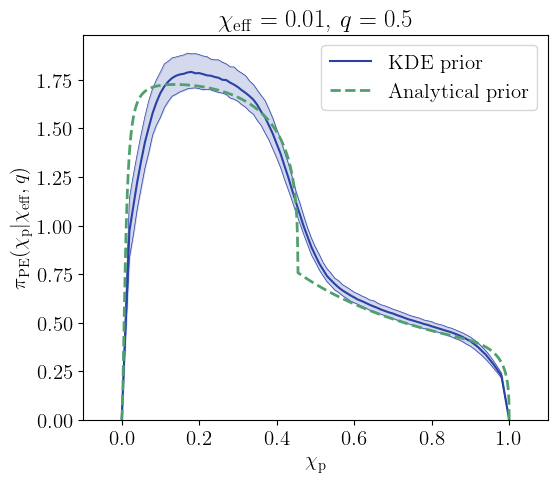

pXp_Xeff_0p01_q_0p80.npy
[0.01, 0.8]


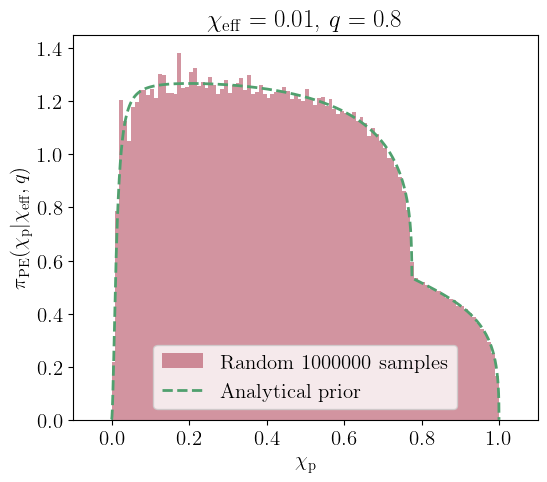

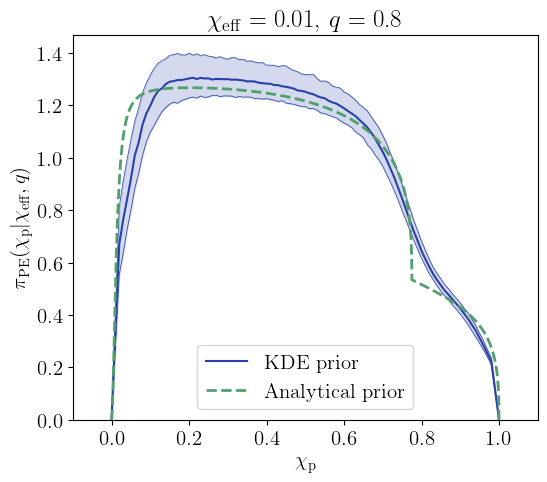

pXp_Xeff_0p01_q_1p00.npy
[0.01, 1.0]


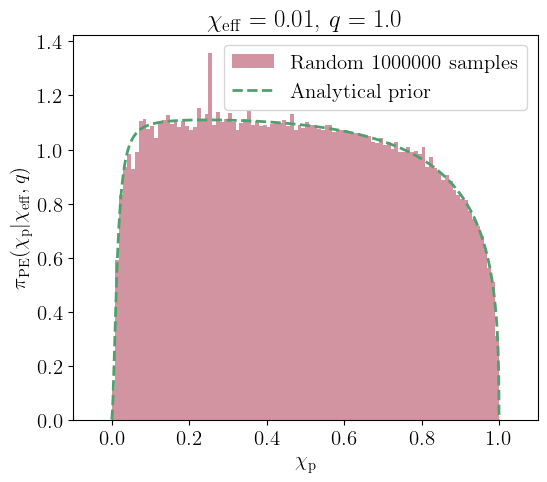

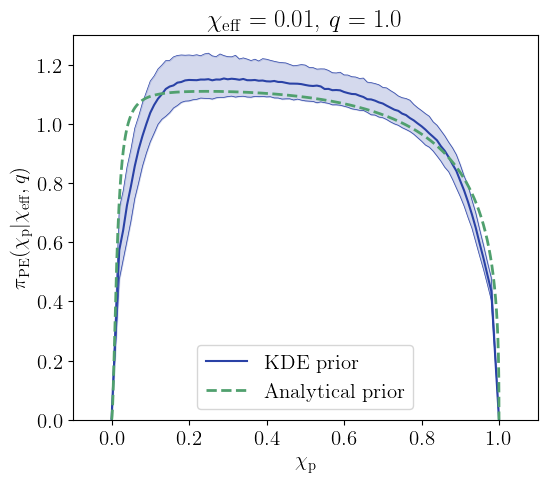

pXp_Xeff_0p10_q_0p20.npy
[0.1, 0.2]


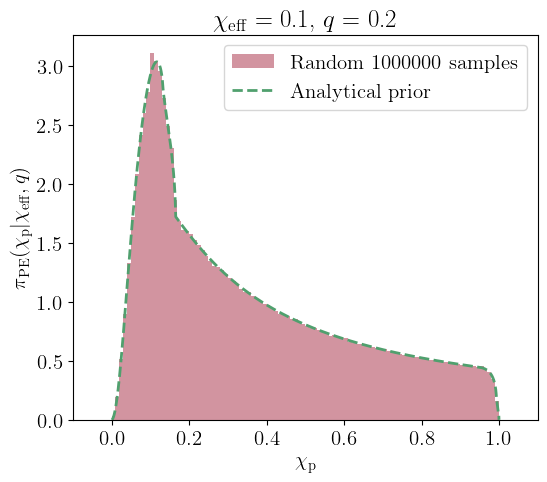

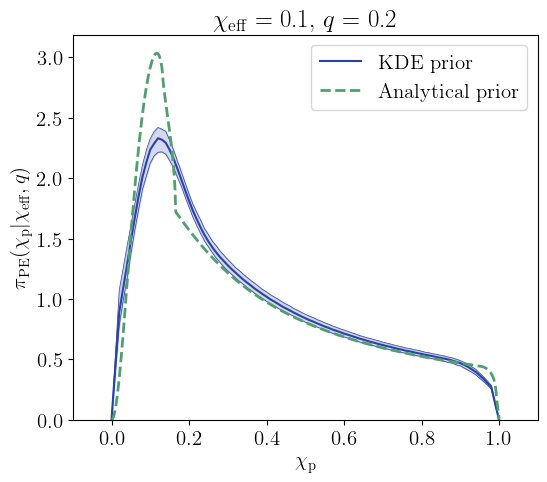

pXp_Xeff_0p10_q_0p50.npy
[0.1, 0.5]


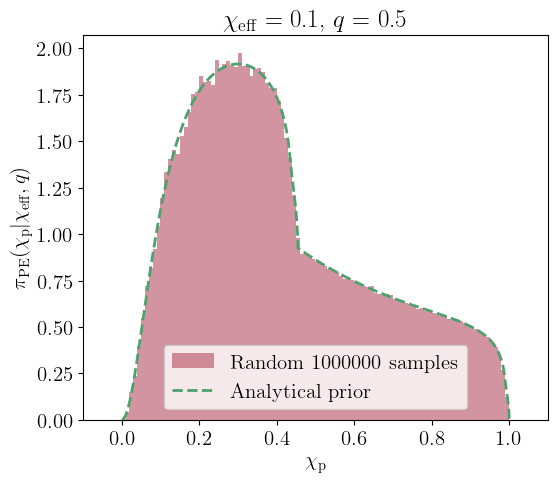

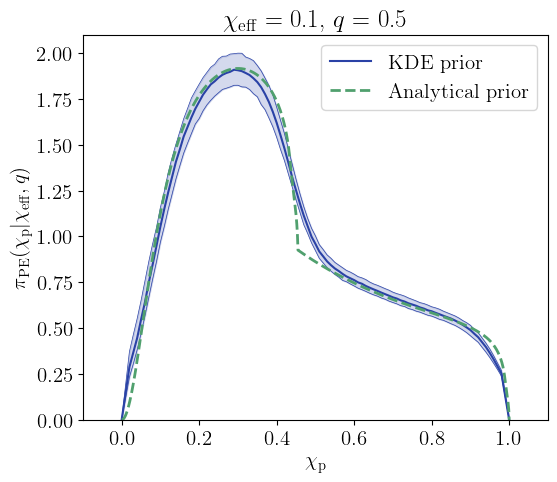

pXp_Xeff_0p10_q_0p80.npy
[0.1, 0.8]


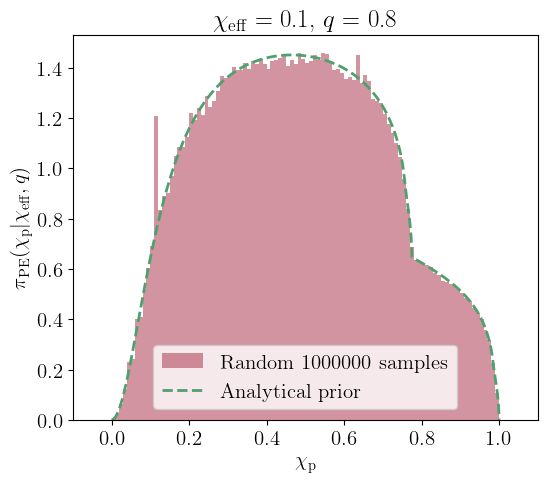

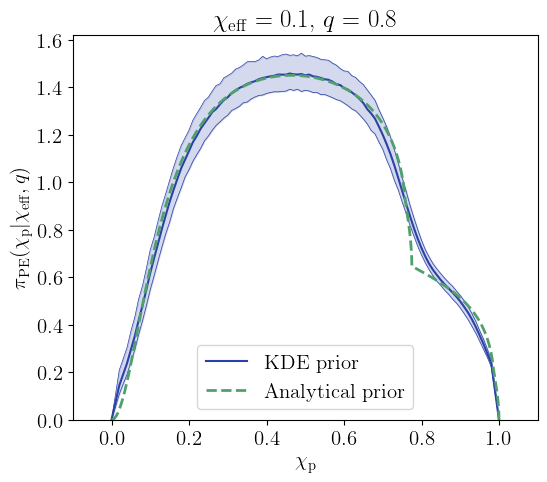

pXp_Xeff_0p10_q_1p00.npy
[0.1, 1.0]


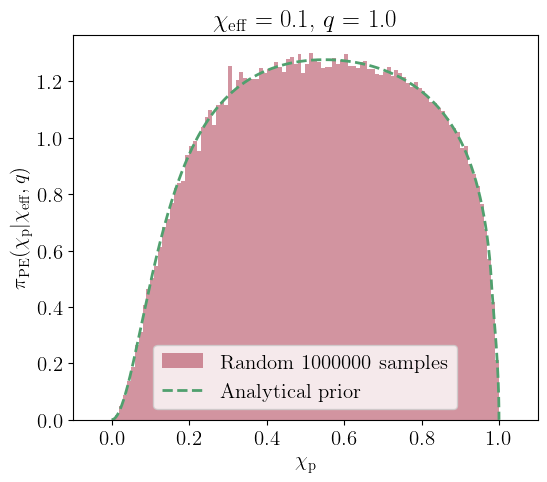

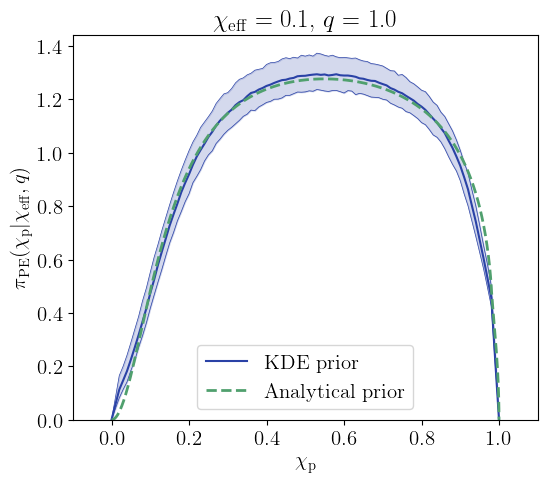

pXp_Xeff_0p20_q_0p20.npy
[0.2, 0.2]


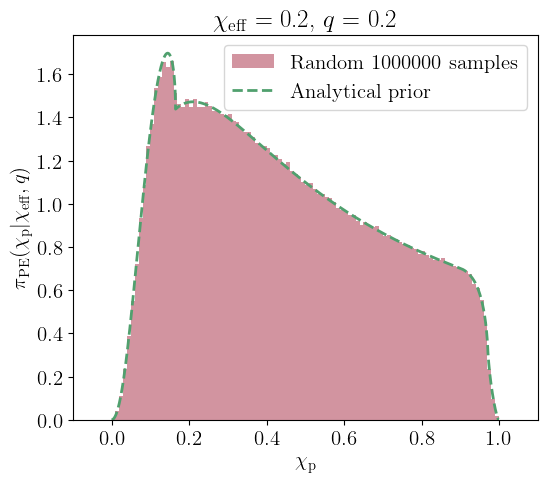

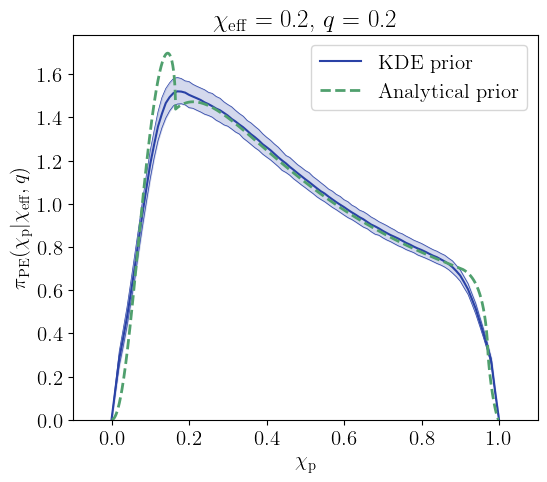

pXp_Xeff_0p20_q_0p50.npy
[0.2, 0.5]


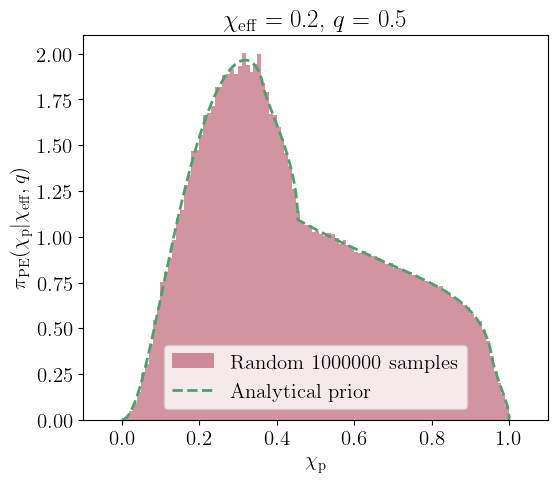

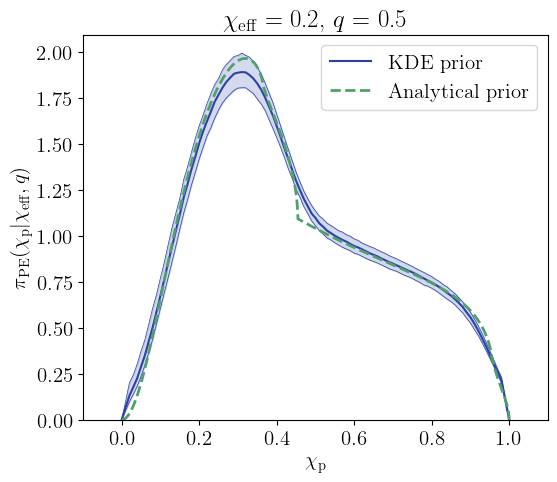

pXp_Xeff_0p20_q_0p80.npy
[0.2, 0.8]


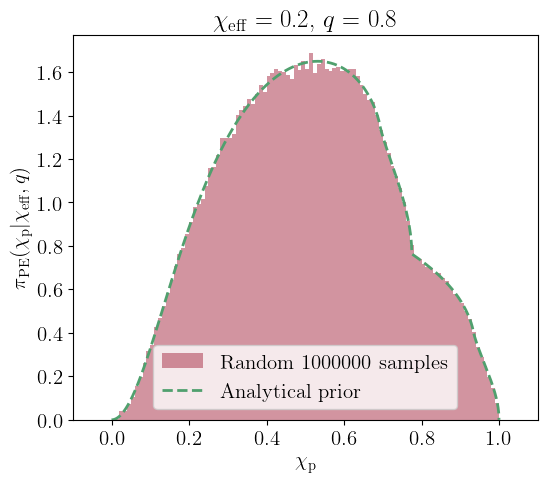

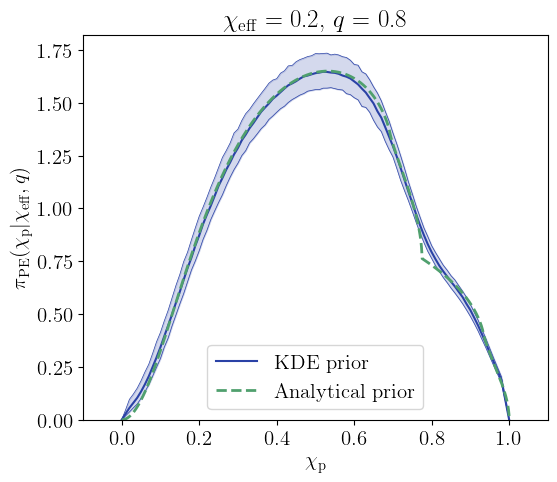

pXp_Xeff_0p20_q_1p00.npy
[0.2, 1.0]


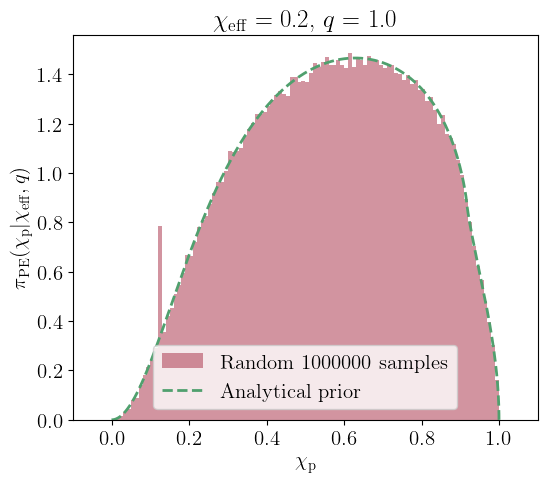

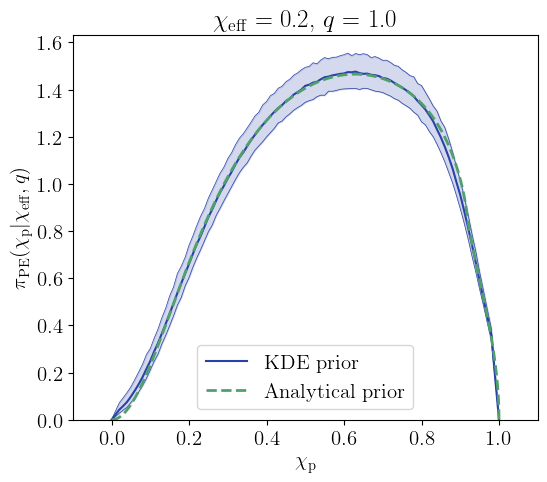

pXp_Xeff_0p50_q_0p20.npy
[0.5, 0.2]


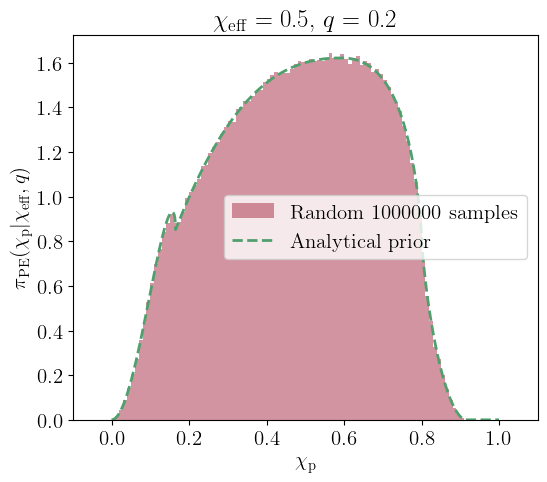

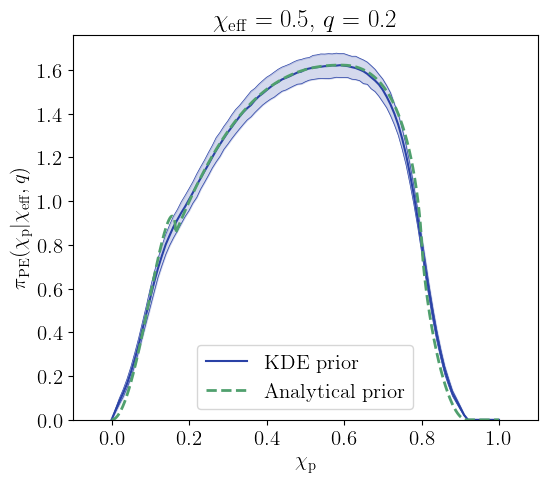

pXp_Xeff_0p50_q_0p50.npy
[0.5, 0.5]


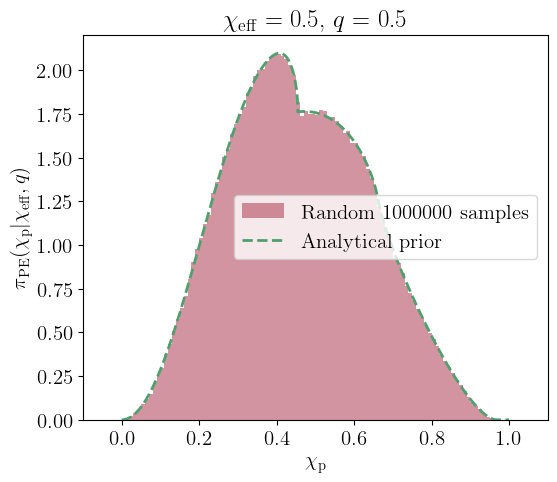

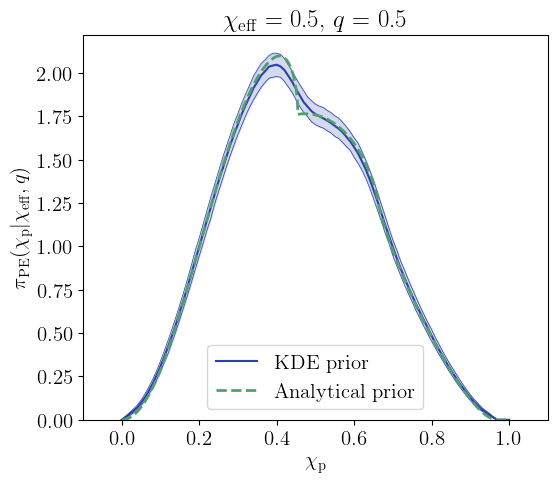

pXp_Xeff_0p50_q_0p80.npy
[0.5, 0.8]


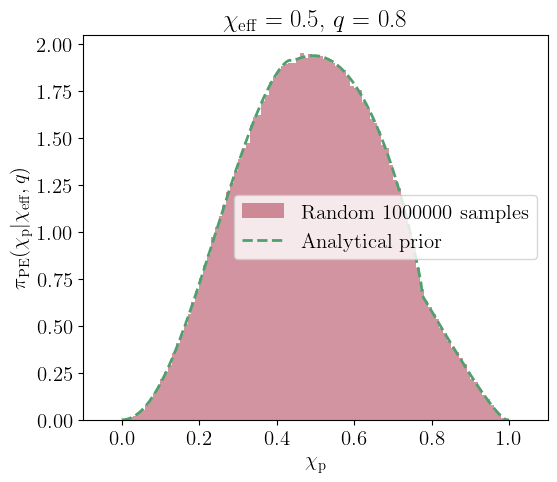

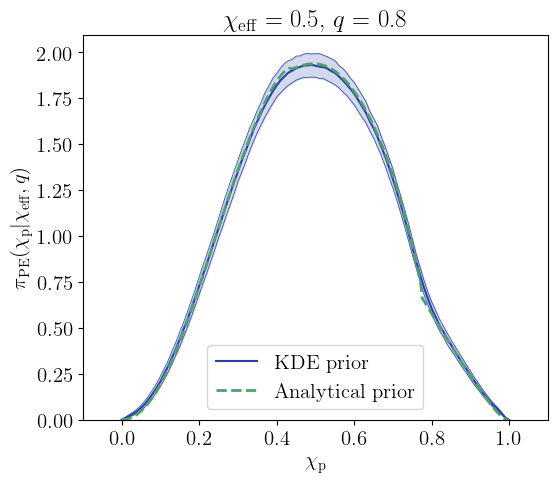

pXp_Xeff_0p50_q_1p00.npy
[0.5, 1.0]


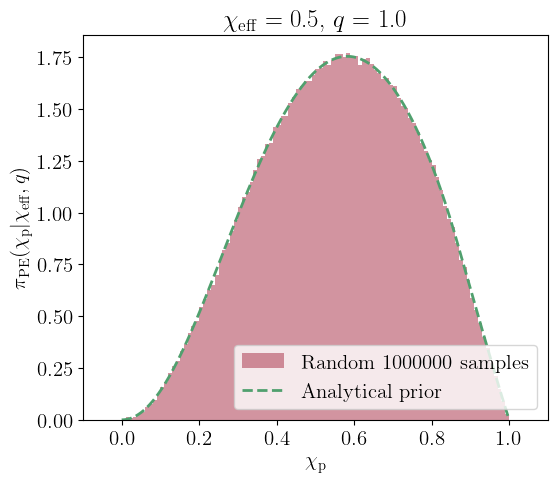

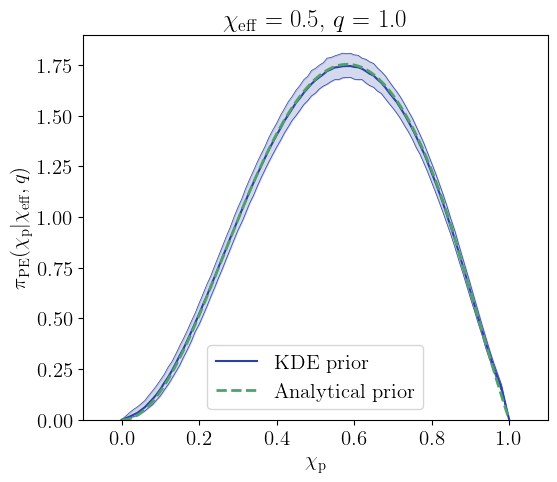

In [12]:
from tqdm.auto import tqdm
import time

ndraws = 1000000

aMax = 1


for file in sorted(os.listdir(calculation_path)):
    if file.startswith('pXp_Xeff_'):
        print(file)
        plt.figure(figsize=(6,5))
        Xp_grid = np.linspace(0,1,101)
        
        data = np.load(calculation_path+file)
        lst = [l for l in file.split('_')]
        llst = []
        for l in lst:
            if '0' in l:
                llst.append(float(l.replace('.npy','').replace('p','.')))
        print(llst)
        
        target_Xeff,q = llst
                
        
        #Draw Histogram
        #Same method when KDE prior construct pdf
        a1,a2,cost2 = np.zeros((3,ndraws))    
        cost1 = np.ones(ndraws)*2
        
        while np.any(cost1<-1) or np.any(cost1>1):   
            to_replace = np.where((cost1<-1) | (cost1>1))[0]   
            a1[to_replace] = np.random.random(to_replace.size)*aMax
            a2[to_replace] = np.random.random(to_replace.size)*aMax
            cost2[to_replace] = 2.*np.random.random(to_replace.size)-1.    
            cost1 = (target_Xeff*(1.+q) - q*a2*cost2)/a1
        
        plt.hist(chi_p(a1,a2,cost1,cost2,q),range=[0,1],weights=(1.+q)/a1,bins=100,density = True,
                 alpha=0.5,label='Random {} samples'.format(ndraws),color=plot_red)
        
        
        #Draw KDE prior
        #unnorm_KDE = data[:,i]
        #norm_KDE_priors = unnorm_KDE/((np.sum(unnorm_KDE))*(Xp_grid[1]-Xp_grid[0]))
        #plt.plot(Xp_grid,norm_KDE_priors,color=plot_blue,label='KDE prior')
        
        #Draw Analytic prior
        Xp_grid = np.linspace(0,1,10001)
        unnormalized_pXp = Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q)
        normalized_pXp = unnormalized_pXp/((np.sum(unnormalized_pXp))*(Xp_grid[1]-Xp_grid[0]))
        plt.plot(Xp_grid,normalized_pXp,label='Analytical prior',color=plot_green,linewidth=2,linestyle='--')
        
        
        if (1+q)*target_Xeff <= 1:
            X2_limit = (3+4*q)/(4+3*q)*np.sqrt(q*q)
        else:
            X2_limit = (3+4*q)/(4+3*q)*np.sqrt(q*q-(1-(1+q)*target_Xeff)**2)
        #plt.axvline(X2_limit,label='{}'.format((3+4*q)/(4+3*q)*np.sqrt(q*q)))
        plt.title(r'$\chi_{\rm eff}$ = '+'{}, $q$ = {}'.format(target_Xeff,q))
        plt.xlabel(r'$\chi_{\rm p}$')
        plt.ylabel(r'$\pi_{\rm PE}(\chi_{\rm p}|\chi_{\rm eff},q)$')
        plt.legend()
        plt.xlim([-0.1,1.1])
        plt.savefig(output_path+file.replace('.npy','_vs_Hist.pdf'))    
        plt.show()        
        
        #Draw KDE prior
        plt.figure(figsize=(6,5))
        Xp_grid = np.linspace(0,1,101)
        unnormalized_pXp = Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q)
        data /= ((np.sum(unnormalized_pXp))*(Xp_grid[1]-Xp_grid[0]))
        plt.plot(Xp_grid,np.quantile(data,axis=1,q=0.5),color=plot_blue,label='KDE prior')
        plt.plot(Xp_grid,np.quantile(data,axis=1,q=0.05),color=plot_blue,linewidth=0.5)
        plt.plot(Xp_grid,np.quantile(data,axis=1,q=0.95),color=plot_blue,linewidth=0.5)
        plt.fill_between(Xp_grid,np.quantile(data,q=0.05,axis=1),np.quantile(data,q=0.95,axis=1),color=plot_blue,alpha=0.2)
        
        #Draw Analytic prior
        Xp_grid = np.linspace(0,1,10001)
        unnormalized_pXp = Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q)
        normalized_pXp = unnormalized_pXp/((np.sum(unnormalized_pXp))*(Xp_grid[1]-Xp_grid[0]))
        plt.plot(Xp_grid,normalized_pXp,label='Analytical prior',color=plot_green,linewidth=2,linestyle='--')
        
        
        plt.title(r'$\chi_{\rm eff}$ = '+'{}, $q$ = {}'.format(target_Xeff,q))
        plt.xlabel(r'$\chi_{\rm p}$')
        plt.ylabel(r'$\pi_{\rm PE}(\chi_{\rm p}|\chi_{\rm eff},q)$')
        plt.legend()
        plt.xlim([-0.1,1.1])
        plt.ylim(ymin=0)
        plt.savefig(output_path+file.replace('.npy','.pdf'))
        plt.show()

In [13]:
cdfs[:,998]

NameError: name 'cdfs' is not defined

In [ ]:
cdf.shape

In [ ]:
cdfs.shape

In [ ]:
plt.plot(np.linspace(0,1,101),data[:,0]/np.mean(data[:,0]))

In [ ]:
Xp_grid = np.linspace(0,1,101)
unnormalized_pXp = Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q)

plt.plot(Xp_grid,np.cumsum(unnormalized_pXp)/np.cumsum(unnormalized_pXp)[-1])


plt.title(r'$\chi_{\rm eff}$ = '+'{}, $q$ = {}'.format(target_Xeff,q))
plt.xlabel(r'$\chi_\mathrm{p}$')
plt.ylabel('CDF')

In [ ]:
CDF = np.cumsum(unnormalized_pXp)/np.cumsum(unnormalized_pXp)[-1]
CDF

In [ ]:
for i in range(10):
    cdf = np.cumsum(data[:,i])/np.cumsum(data[:,i])[-1]
    plt.plot(CDF,cdf)
    
plt.show()

In [ ]:
CDF[3]

In [ ]:
data[0,0]

In [ ]:
for target_Xeff in [.2,.1,.01,0]:
    for q in [1,.8,.5,.2]:
        
        savename = 'vs_hist_Xeff_{:.2f}_q_{:.2f}'.format(target_Xeff,q).replace('.','p')+'.pdf'
        #if savename in os.listdir(output_path):
            #print('Xeff={},q={} figure already exists. SKIP.'.format(target_Xeff,q))
            #continue
            
        #Draw Histogram
        #Same method when KDE prio construct pdf
        a1,a2,cost2 = np.zeros((3,ndraws))    
        cost1 = np.ones(ndraws)*2
        
        while np.any(cost1<-1) or np.any(cost1>1):   
            to_replace = np.where((cost1<-1) | (cost1>1))[0]   
            a1[to_replace] = np.random.random(to_replace.size)*aMax
            a2[to_replace] = np.random.random(to_replace.size)*aMax
            cost2[to_replace] = 2.*np.random.random(to_replace.size)-1.    
            cost1 = (target_Xeff*(1.+q) - q*a2*cost2)/a1
        
        plt.hist(chi_p(a1,a2,cost1,cost2,q),range=[0,1],weights=(1.+q)/a1,bins=100,density = True,
                 alpha=0.5,label='Random {} samples'.format(ndraws),color=plot_red)

        
        #Draw Analytic prior
        
        Ngrid =1001
        Xp_grid = np.linspace(0,1,Ngrid)

        unnormalized_pXp = Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q)
        normalized_pXp = unnormalized_pXp/((np.sum(unnormalized_pXp))*(Xp_grid[1]-Xp_grid[0]))
        plt.plot(Xp_grid,normalized_pXp,label='Analytical prior',color=plot_green,linewidth=2)
        
        
        #Draw KDE prior

        Ngrid = 101
        Xp_grid = np.linspace(0,1,Ngrid)
        t0 = time.time()
        unnorm_KDE = np.zeros(Ngrid)
        unnorm_KDE = joint_prior_from_isotropic_spins(q,1,[target_Xeff]*Ngrid,Xp_grid,ndraws=10000)
        norm_KDE_priors = unnorm_KDE/((np.sum(unnorm_KDE))*(Xp_grid[1]-Xp_grid[0]))
        plt.plot(Xp_grid,norm_KDE_priors,label=r"KDE prior ($n_{\rm draw}$"+" = 10000)",color=plot_blue)
        print('Calculation took {:.2e} s'.format(time.time()-t0))
        
        
        plt.title(r'$\chi_{\rm eff}$ = '+'{}, $q$ = {}'.format(target_Xeff,q))
        plt.xlabel(r'$\chi_{\rm p}$')
        plt.ylabel(r'$\pi_{\rm PE}(\chi_{\rm p}|\chi_{\rm eff},q)$')
        plt.legend()
        #plt.savefig(output_path+savename)
        plt.show()


In [ ]:
from tqdm.auto import tqdm
import time

aMax = 1
target_Xeff = 0.1
colors = ['#0a30c7','#f4cb2a','#c70a30']

for q in [1,.8,.5,.2]:
        
    savename = 'ndraws_Xeff_{:.2f}_q_{:.2f}'.format(target_Xeff,q).replace('.','p')+'.pdf'
    #if savename in os.listdir(output_path):
    #    print('Xeff={},q={} figure already exists. SKIP.'.format(target_Xeff,q))
    #    continue        
    
    
    #Draw Analytic prior    
    Ngrid =1001
    Xp_grid = np.linspace(0,1,Ngrid)
    
    unnormalized_pXp = Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q)
    normalized_pXp = unnormalized_pXp/((np.sum(unnormalized_pXp))*(Xp_grid[1]-Xp_grid[0]))
    plt.plot(Xp_grid,normalized_pXp,label='Analytical prior',color='black',linewidth=2)
        
        
    #Draw KDE prior
    Ngrid = 101
    Xp_grid = np.linspace(0,1,Ngrid)
    t0 = time.time()
    #for j,ndraws in enumerate([10000,100000,1000000]):
    for j,ndraws in enumerate([1000,10000,100000]):
        unnorm_KDE = joint_prior_from_isotropic_spins(q,1,[target_Xeff]*Ngrid,Xp_grid,ndraws=ndraws)
        norm_KDE_priors = unnorm_KDE/((np.sum(unnorm_KDE))*(Xp_grid[1]-Xp_grid[0]))
        plt.plot(Xp_grid,norm_KDE_priors,label=r"KDE prior ($n_{\rm draw}$"+" = {})".format(ndraws),color=colors[j])
        print('Calculation took {:.2e} s'.format(time.time()-t0))
        
        
    plt.title(r'$\chi_{\rm eff}$ = '+'{}, $q$ = {}'.format(target_Xeff,q))
    plt.xlabel(r'$\chi_{\rm p}$')
    plt.ylabel(r'$\pi_{\rm PE}(\chi_{\rm p}|\chi_{\rm eff},q)$')
    plt.legend()
    plt.xlim([-0.1,1.1])
    plt.ylim(ymin=0)
    #plt.savefig(output_path+savename)
    plt.show()


In [ ]:
from tqdm.auto import tqdm
import time

#Niter = 10

aMax = 1

for target_Xeff in [.5,.2,.01,0]:
    for q in [1,.8,.5,.2]:        
        savename = 'pXp_Xeff_{:.2f}_q_{:.2f}'.format(target_Xeff,q).replace('.','p')+'.pdf'
        if savename in os.listdir(output_path):
            print('Xeff={},q={} figure already exists. SKIP.'.format(target_Xeff,q))
            continue
        
        #Draw Analytic prior
        
        Ngrid =1001
        Xp_grid = np.linspace(0,1,Ngrid)
        
        pXp = Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q)
        plt.plot(Xp_grid,pXp,label='Analytical prior',color=plot_green,linewidth=2)
        
        
        #Draw KDE prior

        Ngrid = 101
        Xp_grid = np.linspace(0,1,Ngrid)
        t0 = time.time()
        KDE_results = np.zeros((Ngrid,Niter))
        for i in tqdm(range(Niter)):
            pXp_KDE = joint_prior_from_isotropic_spins(q,1,[target_Xeff]*Ngrid,Xp_grid,ndraws=10000)
            KDE_results[:,i] = pXp_KDE
        plt.plot(Xp_grid,np.median(KDE_results,axis=1),color=plot_blue,linewidth=1,label='KDE prior')
        plt.plot(Xp_grid,np.quantile(KDE_results,q=0.95,axis=1),linewidth=0.5,color=plot_blue)
        plt.plot(Xp_grid,np.quantile(KDE_results,q=0.05,axis=1),linewidth=0.5,color=plot_blue)
        plt.fill_between(Xp_grid,np.quantile(KDE_results,q=0.05,axis=1),np.quantile(KDE_results,q=0.95,axis=1),
                            color=plot_blue,alpha=0.2)
        print('Calculation took {:.2f} s'.format(time.time()-t0))
        
        
        plt.title(r'$\chi_{\rm eff}$ = '+'{}, $q$ = {}'.format(target_Xeff,q))
        plt.xlabel(r'$\chi_{\rm p}$')
        plt.ylabel(r'$\propto \pi_{\rm PE}(\chi_{\rm p}|\chi_{\rm eff},q)$')
        plt.xlim([0,1])
        plt.ylim(ymin=0)
        plt.legend()
        plt.savefig(output_path+savename)
        plt.show()


In [ ]:
for target_Xeff in [.5,.2,.01,0]:
    for q in [1,.8,.5,.2]:     
        
        savename = 'pXp_zoomed_Xeff_{:.2f}_q_{:.2f}'.format(target_Xeff,q).replace('.','p')+'.pdf'
        if savename in os.listdir(output_path):
            print('Xeff={},q={} figure already exists. SKIP.'.format(target_Xeff,q))
            continue
        
        #Draw Analytic prior
        
        Ngrid =1001
        Xp_grid = np.linspace(0,.1,Ngrid)
        
        pXp = Joint_prob_Xeff_Xp(target_Xeff,Xp_grid,q)
        plt.plot(Xp_grid,pXp,label='Analytical prior',color=plot_green,linewidth=2)
        
        
        #Draw KDE prior

        Ngrid = 101
        Xp_grid = np.linspace(0,.1,Ngrid)
        t0 = time.time()
        KDE_results = np.zeros((Ngrid,Niter))
        for i in tqdm(range(Niter)):
            pXp_KDE = joint_prior_from_isotropic_spins(q,1,[target_Xeff]*Ngrid,Xp_grid,ndraws=10000)
            KDE_results[:,i] = pXp_KDE
        plt.plot(Xp_grid,np.median(KDE_results,axis=1),color=plot_blue,linewidth=1,label='KDE prior')
        plt.plot(Xp_grid,np.quantile(KDE_results,q=0.95,axis=1),linewidth=0.5,color=plot_blue)
        plt.plot(Xp_grid,np.quantile(KDE_results,q=0.05,axis=1),linewidth=0.5,color=plot_blue)
        plt.fill_between(Xp_grid,np.quantile(KDE_results,q=0.05,axis=1),np.quantile(KDE_results,q=0.95,axis=1),
                            color=plot_blue,alpha=0.2)
        print('Calculation took {:.2f} s'.format(time.time()-t0))
        
        
        plt.title(r'$\chi_{\rm eff}$ = '+'{}, $q$ = {}'.format(target_Xeff,q))
        plt.xlabel(r'$\chi_{\rm p}$')
        plt.ylabel(r'$\propto \pi_{\rm PE}(\chi_{\rm p}|\chi_{\rm eff},q)$')
        plt.xlim([0,.1])
        plt.ylim(ymin=0)
        plt.legend()
        plt.savefig(output_path+savename)
        plt.show()


## $p(\chi_{\rm eff}|\chi_{\rm p},q)$ plots

Since larger $\chi_{\rm eff}$ requires a large number of rerolls (thus computational costs), I limit the region to plot here.

In [ ]:
aMax = 1
Xeff_max = 0.2

for target_Xp in [.5,.2,.1,.01,.001]:
    for q in [1,.8,.5,.2]:
        
        savename = 'pXeff_Xp_{:.2f}_q_{:.2f}'.format(target_Xp,q).replace('.','p')+'.pdf'
        if savename in os.listdir(output_path):
            print('Xp={},q={} figure already exists. SKIP.'.format(target_Xp,q))
            continue
            
            
        #Draw Analytic prior
        
        Ngrid =1001
        Xeff_grid = np.linspace(-Xeff_max,Xeff_max,Ngrid)
        
        pXeff = Joint_prob_Xeff_Xp(Xeff_grid,target_Xp,q)
        plt.plot(Xeff_grid,pXeff,label='Analytical prior',color=plot_green,linewidth=2)
        
        
        #Draw KDE prior

        Niter = 100
        Ngrid = 101
        Xeff_grid = np.linspace(-Xeff_max,Xeff_max,Ngrid)
        t0 = time.time()
        KDE_results = np.zeros((Ngrid,Niter))
        for i in tqdm(range(Niter)):
            pXeff_KDE = joint_prior_from_isotropic_spins(q,1,Xeff_grid,[target_Xp]*Ngrid,ndraws=10000)
            #plt.plot(Xeff_grid,pXeff_KDE,alpha=1/Niter)
            KDE_results[:,i] = pXeff_KDE
        plt.plot(Xeff_grid,np.median(KDE_results,axis=1),color=plot_blue,linewidth=1,label='KDE prior')
        plt.plot(Xeff_grid,np.quantile(KDE_results,q=0.95,axis=1),linewidth=0.5,color=plot_blue)
        plt.plot(Xeff_grid,np.quantile(KDE_results,q=0.05,axis=1),linewidth=0.5,color=plot_blue)
        plt.fill_between(Xeff_grid,np.quantile(KDE_results,q=0.05,axis=1),np.quantile(KDE_results,q=0.95,axis=1),
                            color=plot_blue,alpha=0.2)
        print('Calculation took {:.2f} s'.format(time.time()-t0))
        
        
        plt.title(r'$\chi_{\rm p}$ = '+'{}, $q$ = {}'.format(target_Xp,q))
        plt.xlabel(r'$\chi_{\rm eff}$')
        plt.ylabel(r'$\propto \pi_{\rm PE}(\chi_{\rm eff}|\chi_{\rm p},q)$')
        plt.xlim([-Xeff_max,Xeff_max])
        plt.ylim(ymin=0)
        plt.legend()
        plt.savefig(output_path+savename)
        plt.show()
